<center><h1 style="font-size:40px;"><b>IPL ANALYSIS</b></h1></center>

### SETUP & DATA PREPARATION


In [96]:
import numpy as np
import pandas as pd
import warnings

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from wordcloud import WordCloud

# --- Modeling Libraries ---
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, mean_squared_error,
    roc_auc_score, f1_score
)
import lightgbm as lgb
import xgboost as xgb 

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

np.random.seed(42)

# Ensure Plotly renders inline in Jupyter Notebook
pio.renderers.default = 'notebook_connected'  # 'notebook_connected' works better in classic Jupyter


### LOAD AND PREPARE THE DATA

In [64]:
df = pd.read_csv('IPL.csv')

# Drop redundant unnamed index column, if present
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

# Convert 'date' to datetime format
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Use 'coerce' to handle invalid formats safely
    df['year'] = df['date'].dt.year
else:
    print(f"'date' column not found.")

# Drop duplicate match entries to form match-level DataFrame
if 'match_id' in df.columns:
    matches_df = df.drop_duplicates(subset='match_id', keep='first').copy()
else:
    print("'match_id' column not found. Cannot create match-level DataFrame.")

print(f" Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("Data loaded and preprocessed.")


 Dataset shape: (278205, 63)
Columns: ['match_id', 'date', 'match_type', 'event_name', 'innings', 'batting_team', 'bowling_team', 'over', 'ball', 'ball_no', 'batter', 'bat_pos', 'runs_batter', 'balls_faced', 'bowler', 'valid_ball', 'runs_extras', 'runs_total', 'runs_bowler', 'runs_not_boundary', 'extra_type', 'non_striker', 'non_striker_pos', 'wicket_kind', 'player_out', 'fielders', 'runs_target', 'review_batter', 'team_reviewed', 'review_decision', 'umpire', 'umpires_call', 'player_of_match', 'match_won_by', 'win_outcome', 'toss_winner', 'toss_decision', 'venue', 'city', 'day', 'month', 'year', 'season', 'gender', 'team_type', 'superover_winner', 'result_type', 'method', 'balls_per_over', 'overs', 'event_match_no', 'stage', 'match_number', 'team_runs', 'team_balls', 'team_wicket', 'new_batter', 'batter_runs', 'batter_balls', 'bowler_wicket', 'batting_partners', 'next_batter', 'striker_out']
Data loaded and preprocessed.


### Mapping old team names to new names

In [3]:
team_name_map = {
    'Royal Challengers Bangalore': 'Royal Challengers Bengaluru',
    'Delhi Daredevils': 'Delhi Capitals',
    'Kings XI Punjab': 'Punjab Kings'
}

# Replace in all relevant columns, e.g., 'batting_team', 'bowling_team', 'toss_winner', 'match_won_by', etc.
cols_to_replace = ['batting_team', 'bowling_team', 'toss_winner', 'match_won_by']

for col in cols_to_replace:
    if col in df.columns:
        df[col] = df[col].replace(team_name_map)


### Drop columns that are not useful for the analysis

In [65]:
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# Check for missing values
missing_values = df.isnull().sum()
print('Missing Values in Each Column:')
print(missing_values[missing_values > 0])

# Handle some missing values if critical
if 'wicket_kind' in df.columns:
    df['wicket_kind'].fillna('Not Out', inplace=True)

# Ensure relevant numeric columns are in proper format
numeric_cols = ['match_id', 'innings', 'over', 'ball', 'bat_pos', 'runs_batter', 
                'balls_faced', 'valid_ball', 'runs_extras', 'runs_total', 'runs_bowler', 
                'non_striker_pos', 'day', 'month', 'year', 'balls_per_over', 'overs', 
                'team_runs', 'team_balls', 'team_wicket', 'batter_runs', 'batter_balls', 'bowler_wicket']

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Check duplicates
print(f'Total duplicate rows: {df.duplicated().sum()}')

print('Data types after cleaning:')
print(df.dtypes)

print(f'Dataset shape after cleaning: {df.shape}')
print(df.head())


Missing Values in Each Column:
extra_type          263072
wicket_kind         264382
player_out          264382
fielders            268192
runs_target         144302
review_batter       277333
team_reviewed       277333
review_decision     277333
umpire              277333
win_outcome           4702
superover_winner    274309
result_type         273503
method              274315
new_batter          264884
next_batter         264884
dtype: int64
Total duplicate rows: 0
Data types after cleaning:
match_id                      int64
date                 datetime64[ns]
match_type                   object
event_name                   object
innings                       int64
batting_team                 object
bowling_team                 object
over                          int64
ball                          int64
ball_no                     float64
batter                       object
bat_pos                       int64
runs_batter                   int64
balls_faced                   in

<center><h1 style="font-size:40px;"><b>EDA</b></h1></center>


# Total Number of Matches

In [68]:
total_matches = df['match_id'].nunique()

# Total matches per season
matches_per_season = df.drop_duplicates(subset=['match_id']).groupby('season')['match_id'].count()

print(f"Total matches played (2008-2025): {total_matches}")
print("Matches played per season:")
print(matches_per_season)


Total matches played (2008-2025): 1169
Matches played per season:
season
2009       34
2011       41
2012       74
2013       76
2014       60
2015       59
2016       60
2017       59
2018       60
2019       31
2021       47
2022       74
2023       74
2024       71
2025       74
2007/08    58
2009       23
2009/10    60
2011       32
2019       29
2020/21    60
2021       13
Name: match_id, dtype: int64


In [6]:
# Your corrected match counts by season
corrected_match_counts = {
    2008: 58, 2009: 57, 2010: 60, 2011: 73, 2012: 74,
    2013: 76, 2014: 60, 2015: 59, 2016: 60, 2017: 59,
    2018: 60, 2019: 60, 2020: 60, 2021: 60, 2022: 74,
    2023: 74, 2024: 71, 2025: 74
}


In [7]:
# Normalize season to final year
def season_to_year(season):
    season = str(season)
    if '/' in season:
        return int('20' + season.split('/')[1])  # e.g., '2007/08' → 2008
    return int(season)

# Apply it
df['season_year'] = df['season'].apply(season_to_year)


In [8]:
# Replace original counts with corrected ones
matches_per_season = pd.Series(corrected_match_counts).sort_index()


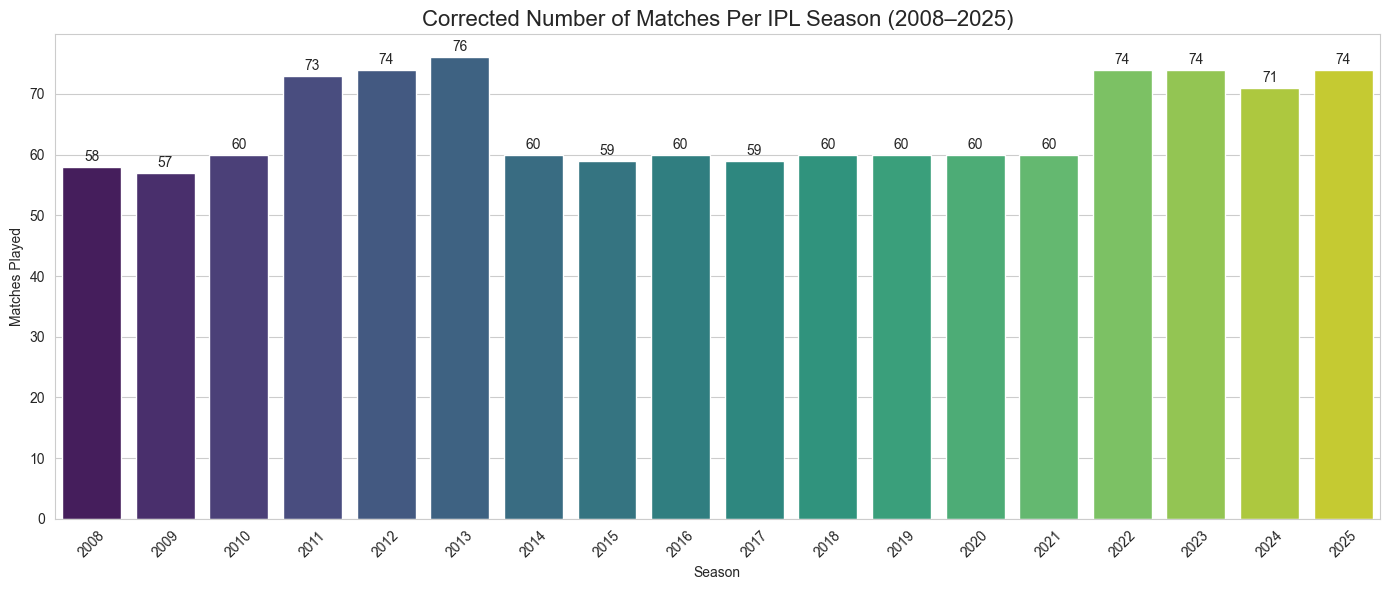

In [9]:
plt.figure(figsize=(14,6))
sns.barplot(x=matches_per_season.index, y=matches_per_season.values, palette='viridis')

plt.title("Corrected Number of Matches Per IPL Season (2008–2025)", fontsize=16)
plt.xlabel("Season")
plt.ylabel("Matches Played")
plt.xticks(rotation=45)

# Add value labels on top
for i, val in enumerate(matches_per_season.values):
    plt.text(i, val + 1, str(val), ha='center', fontsize=10)

plt.tight_layout()
plt.show()


# Total number of matches won by each team

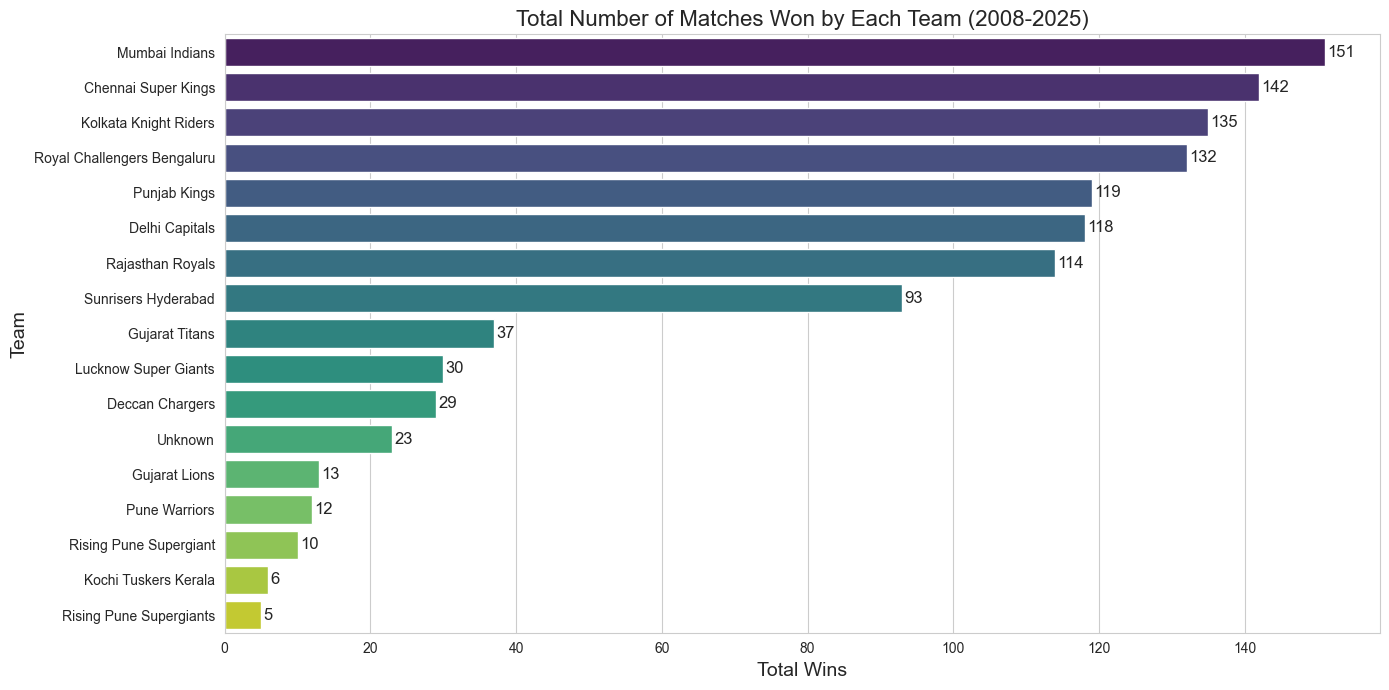

In [67]:
import matplotlib.ticker as mticker

# Map old team names to updated names
team_name_map = {
    'Royal Challengers Bangalore': 'Royal Challengers Bengaluru',
    'Delhi Daredevils': 'Delhi Capitals',
    'Kings XI Punjab': 'Punjab Kings'
}

# Replace old names with new ones in 'match_won_by' column
df['match_won_by'] = df['match_won_by'].replace(team_name_map)

# Remove matches with no winner (like ties or no results)
matches = df.drop_duplicates('match_id')
matches = matches[matches['match_won_by'].notnull()]

# Count total wins per team
wins_per_team = matches.groupby('match_won_by').size().reset_index(name='Total Wins')
wins_per_team = wins_per_team.sort_values('Total Wins', ascending=False).reset_index(drop=True)

plt.figure(figsize=(14,7))
sns.barplot(data=wins_per_team, y='match_won_by', x='Total Wins', palette='viridis')
plt.title('Total Number of Matches Won by Each Team (2008-2025)', fontsize=16)
plt.xlabel('Total Wins', fontsize=14)
plt.ylabel('Team', fontsize=14)

# Add count labels to bars
for i, row in wins_per_team.iterrows():
    plt.text(row['Total Wins'] + 0.3, i, row['Total Wins'], va='center', fontsize=12)

# Optional: format x-axis ticks nicely
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


# Does winning the toss affect the match winner?

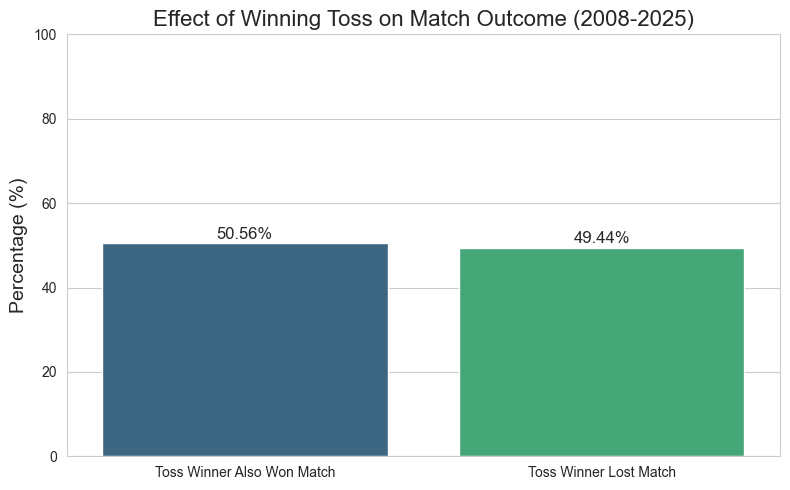

In [66]:
matches_toss = matches[matches['toss_winner'].notnull() & matches['match_won_by'].notnull()]

# Create a column to check if toss winner is also match winner
matches_toss['toss_win_match_win'] = (matches_toss['toss_winner'] == matches_toss['match_won_by'])

# Calculate counts
toss_match_result = matches_toss['toss_win_match_win'].value_counts().rename(index={True: 'Toss Winner Also Won Match', False: 'Toss Winner Lost Match'})

# Percentage calculation
toss_match_percent = (toss_match_result / toss_match_result.sum()) * 100

# Plotting
plt.figure(figsize=(8,5))
sns.barplot(x=toss_match_percent.index, y=toss_match_percent.values, palette='viridis')
plt.title('Effect of Winning Toss on Match Outcome (2008-2025)', fontsize=16)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xlabel('')
plt.ylim(0, 100)

# Annotate percentages
for i, val in enumerate(toss_match_percent.values):
    plt.text(i, val + 1, f'{val:.2f}%', ha='center', fontsize=12)

plt.tight_layout()
plt.show()


# Toss/Win Ratio by Teams

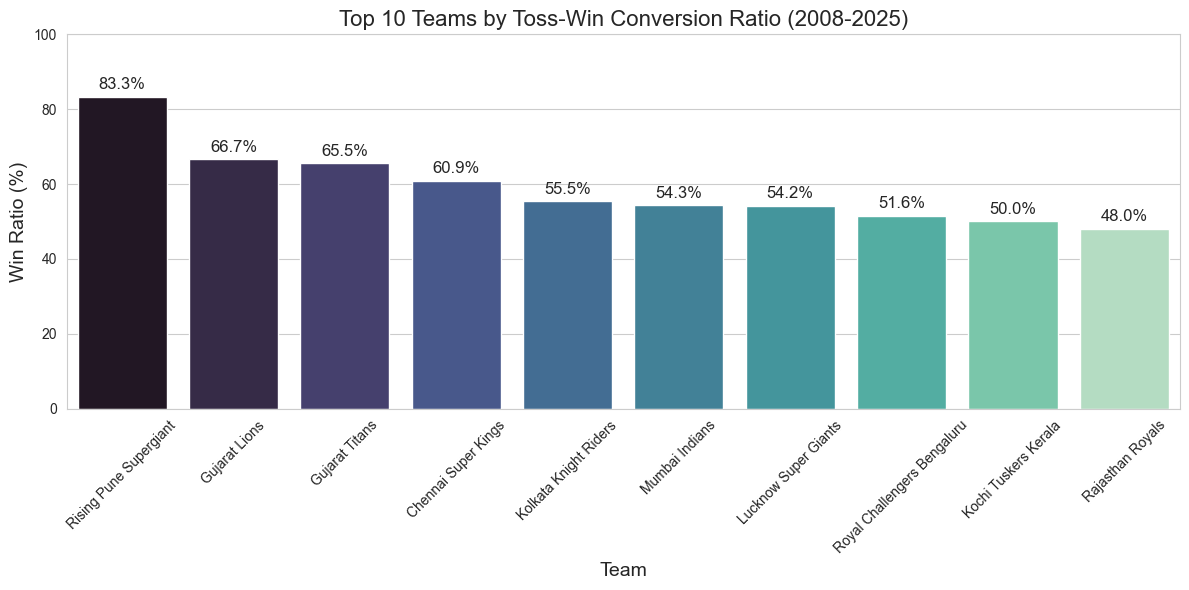

In [12]:
# Prepare DataFrame with toss winner, match winner, and match_id
toss_win_data = matches[['match_id', 'toss_winner', 'match_won_by']].dropna()

# Filter only teams present in toss_winner and match_won_by
teams = toss_win_data['toss_winner'].unique()

# Calculate toss wins count and toss & match wins count per team
toss_wins_count = toss_win_data['toss_winner'].value_counts()
toss_and_match_wins = toss_win_data[toss_win_data['toss_winner'] == toss_win_data['match_won_by']]
toss_and_match_wins_count = toss_and_match_wins['toss_winner'].value_counts()

# Create DataFrame for ratio
toss_win_ratio_df = pd.DataFrame({
    'Toss Wins': toss_wins_count,
    'Match Wins After Toss': toss_and_match_wins_count
}).fillna(0)

toss_win_ratio_df['Win Ratio (%)'] = (toss_win_ratio_df['Match Wins After Toss'] / toss_win_ratio_df['Toss Wins']) * 100

# Sort by Win Ratio
toss_win_ratio_df = toss_win_ratio_df.sort_values('Win Ratio (%)', ascending=False)

# Plot top 10 teams with best toss-win ratios
plt.figure(figsize=(12,6))
sns.barplot(
    x=toss_win_ratio_df.head(10).index,
    y=toss_win_ratio_df.head(10)['Win Ratio (%)'],
    palette='mako'
)
plt.title('Top 10 Teams by Toss-Win Conversion Ratio (2008-2025)', fontsize=16)
plt.ylabel('Win Ratio (%)', fontsize=14)
plt.xlabel('Team', fontsize=14)
plt.ylim(0, 100)

# Annotate bars with values
for i, val in enumerate(toss_win_ratio_df.head(10)['Win Ratio (%)']):
    plt.text(i, val + 2, f'{val:.1f}%', ha='center', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Most Player of the Match Awards



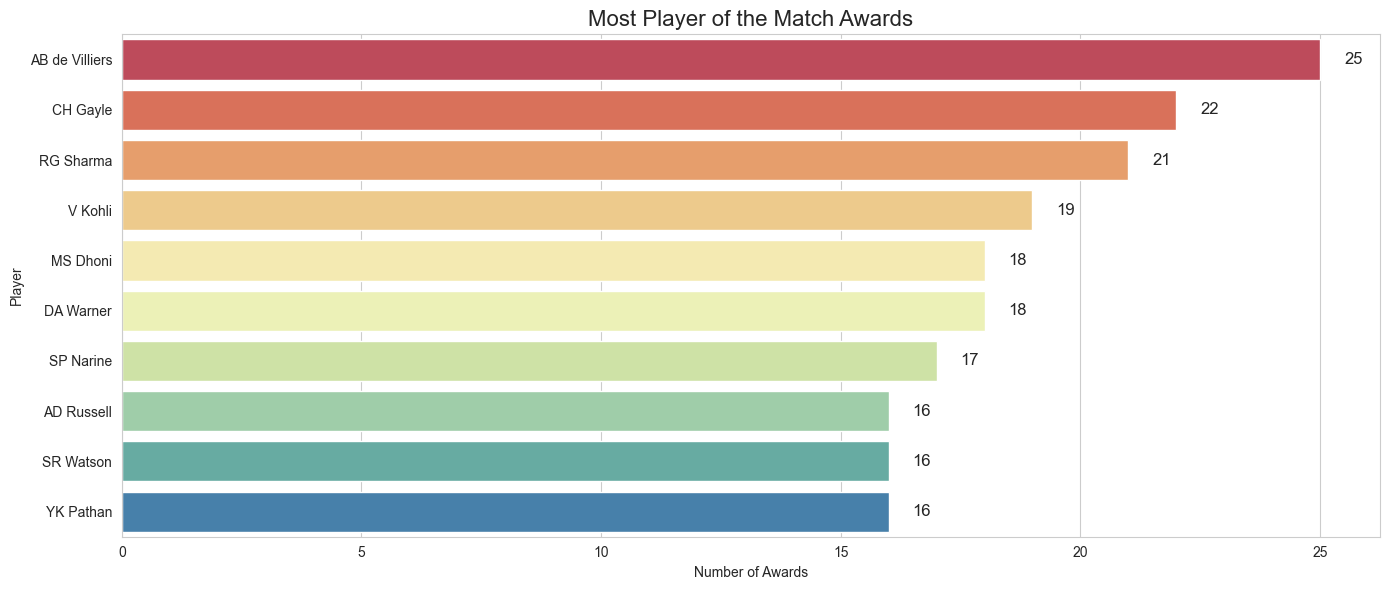

In [13]:
# Get unique matches for player_of_match counts
matches_df = df.drop_duplicates('match_id')

# Count Player of the Match awards
mom_counts = matches_df['player_of_match'].value_counts().reset_index()
mom_counts.columns = ['Player', 'Awards']

# Get top 10 players
top_mom = mom_counts.head(10)

# Plot
plt.figure(figsize=(14,6))
sns.barplot(data=top_mom, y='Player', x='Awards', palette='Spectral')
plt.title('Most Player of the Match Awards', fontsize=16)
plt.xlabel('Number of Awards')
plt.ylabel('Player')

for i, row in top_mom.iterrows():
    plt.text(row['Awards'] + 0.5, i, row['Awards'], va='center', fontsize=12)

plt.tight_layout()
plt.show()


# Success Rate of Winning Matches by Teams 

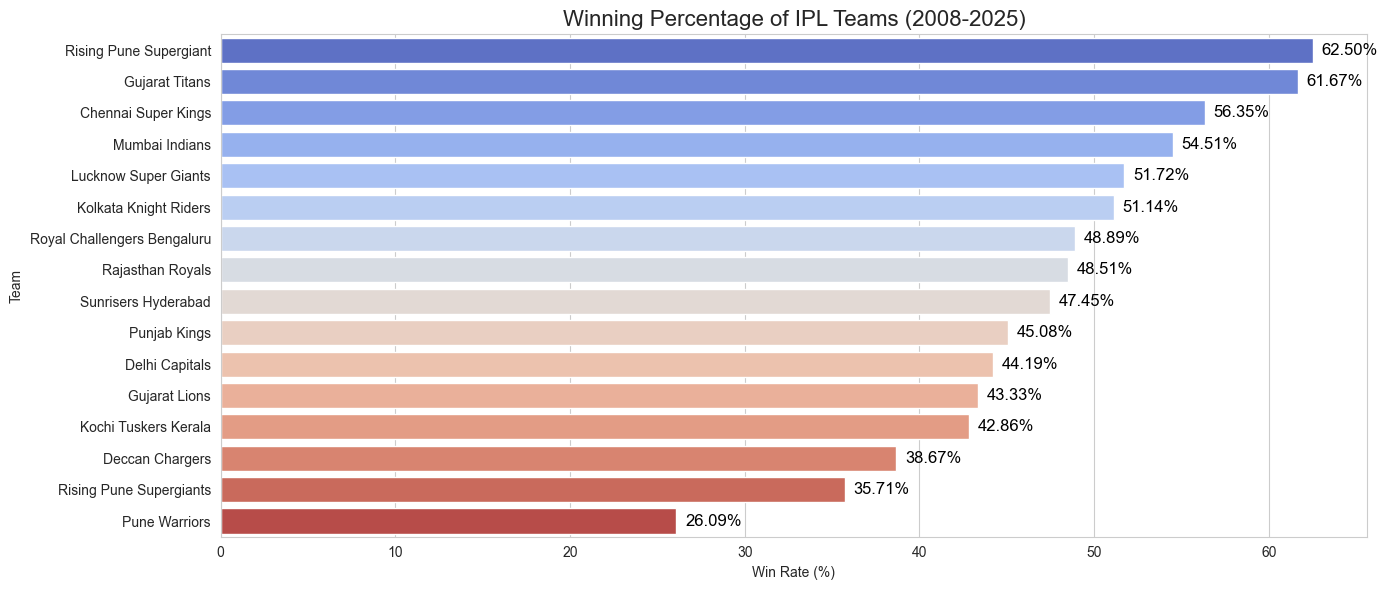

In [14]:
import numpy as np

# Map old team names in toss_winner and match_won_by for consistency
df['toss_winner'] = df['toss_winner'].replace(team_name_map)
df['match_won_by'] = df['match_won_by'].replace(team_name_map)

# Extract unique matches played by teams (batting + bowling combined)
matches_batting = df.drop_duplicates('match_id')[['match_id', 'batting_team']].rename(columns={'batting_team': 'team'})
matches_bowling = df.drop_duplicates('match_id')[['match_id', 'bowling_team']].rename(columns={'bowling_team': 'team'})

# Combine and get unique matches per team
all_matches = pd.concat([matches_batting, matches_bowling]).drop_duplicates()

matches_per_team = all_matches.groupby('team')['match_id'].nunique().reset_index()
matches_per_team.columns = ['team', 'matches_played']

# Wins per team (from unique matches)
wins_per_team = df.drop_duplicates('match_id').groupby('match_won_by').size().reset_index(name='wins')
wins_per_team.rename(columns={'match_won_by': 'team'}, inplace=True)

# Merge and calculate win rate
team_performance = pd.merge(matches_per_team, wins_per_team, on='team', how='left').fillna(0)
team_performance['win_rate'] = (team_performance['wins'] / team_performance['matches_played']) * 100
team_performance = team_performance.sort_values('win_rate', ascending=False).reset_index(drop=True)

plt.figure(figsize=(14,6))
bars = sns.barplot(data=team_performance, y='team', x='win_rate', palette='coolwarm')

plt.title('Winning Percentage of IPL Teams (2008-2025)', fontsize=16)
plt.xlabel('Win Rate (%)')
plt.ylabel('Team')

# Annotate bars with win rate values
for i, row in team_performance.iterrows():
    win_rate = row['win_rate']
    plt.text(win_rate + 0.5 if win_rate < 90 else win_rate - 8, i, f"{win_rate:.2f}%", 
             va='center', ha='left' if win_rate < 90 else 'right', fontsize=12, color='black')

plt.tight_layout()
plt.show()


<center><h1 style="font-size:40px;"><b>TOSS ANALYSIS</b></h1></center>






# Total Toss wins by teams

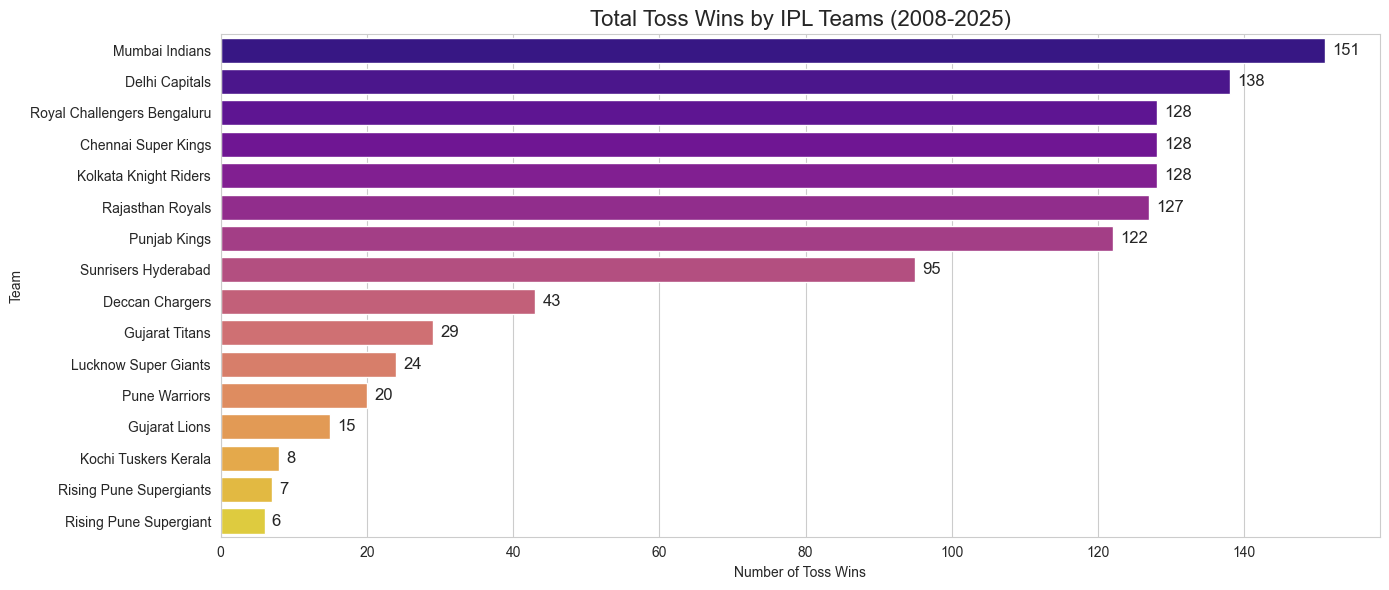

In [15]:
# Map team names in toss_winner for consistency (if not done earlier)
df['toss_winner'] = df['toss_winner'].replace(team_name_map)

# Count toss wins by team
toss_wins = df.drop_duplicates('match_id')['toss_winner'].value_counts().reset_index()
toss_wins.columns = ['team', 'toss_wins']

plt.figure(figsize=(14,6))
sns.barplot(data=toss_wins, y='team', x='toss_wins', palette='plasma')
plt.title('Total Toss Wins by IPL Teams (2008-2025)', fontsize=16)
plt.xlabel('Number of Toss Wins')
plt.ylabel('Team')

for i, row in toss_wins.iterrows():
    plt.text(row['toss_wins'] + 1, i, row['toss_wins'], va='center', fontsize=12)

plt.tight_layout()
plt.show()


# Toss Wins Per Season Trend

<Figure size 1600x700 with 0 Axes>

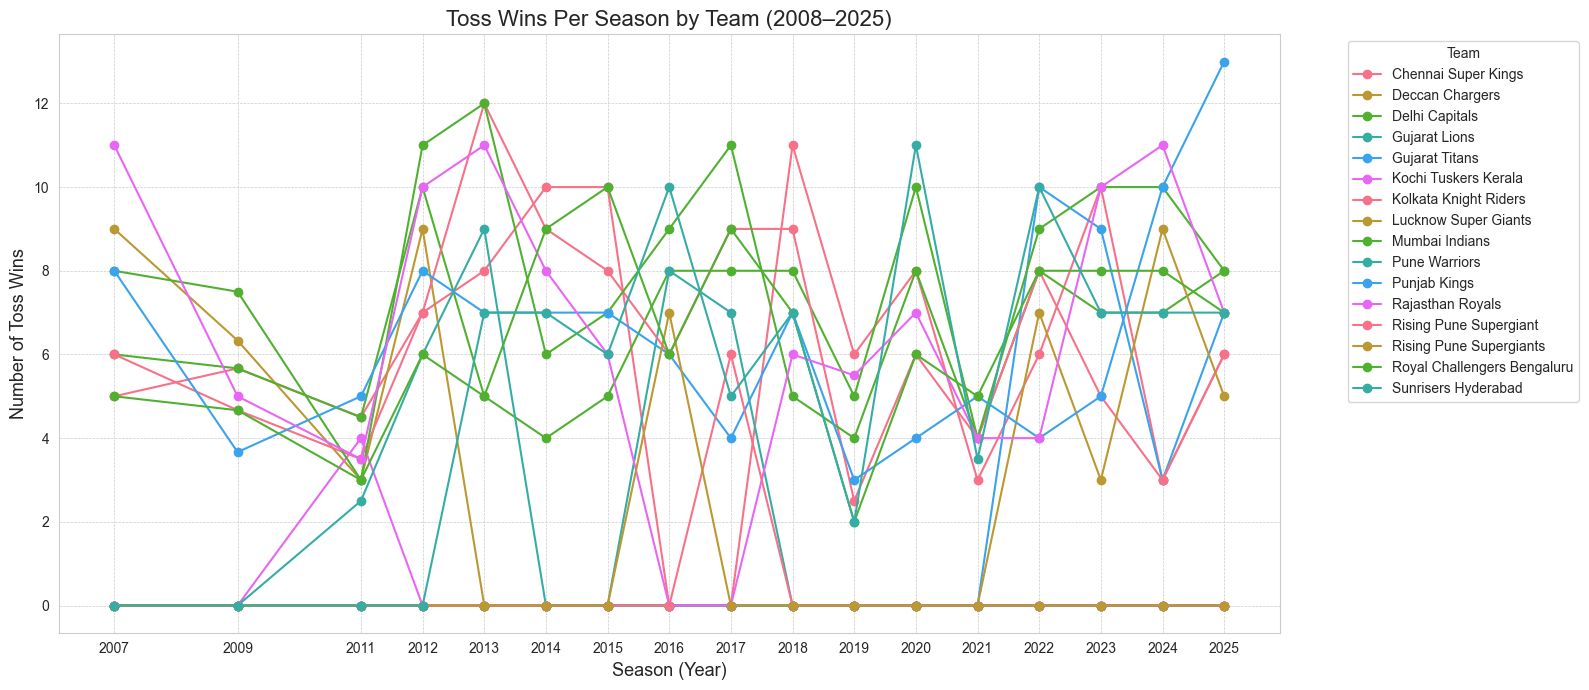

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
toss_data = df.drop_duplicates('match_id')[['season', 'toss_winner']]
toss_wins_season = toss_data.groupby(['season', 'toss_winner']).size().reset_index(name='Toss Wins')

# Clean season labels to sort correctly
def season_to_year(season):
    season = str(season)
    if '/' in season:
        return int(season.split('/')[0])
    return int(season)

toss_wins_season['Year'] = toss_wins_season['season'].apply(season_to_year)

# Pivot for lineplot
toss_trend = toss_wins_season.pivot_table(index='Year', columns='toss_winner', values='Toss Wins', fill_value=0)

# Plot
plt.figure(figsize=(16, 7))
sns.set_style("whitegrid")
sns.set_palette("husl")  # vivid, distinguishable lines

toss_trend.plot(kind='line', marker='o', figsize=(16, 7))

plt.title('Toss Wins Per Season by Team (2008–2025)', fontsize=16)
plt.xlabel('Season (Year)', fontsize=13)
plt.ylabel('Number of Toss Wins', fontsize=13)
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(sorted(toss_trend.index))
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


# Toss Winner vs Match Winner

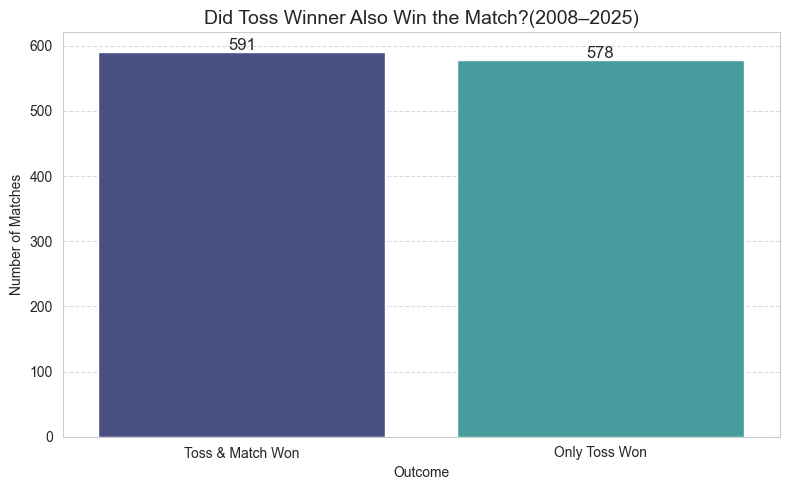

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter unique matches only
toss_vs_match = df.drop_duplicates('match_id')[['toss_winner', 'match_won_by']]

# Create result column
toss_vs_match['Toss Impact'] = toss_vs_match.apply(
    lambda x: 'Toss & Match Won' if x['toss_winner'] == x['match_won_by'] else 'Only Toss Won', axis=1
)

# Count impact
toss_impact_count = toss_vs_match['Toss Impact'].value_counts().reset_index()
toss_impact_count.columns = ['Outcome', 'Count']

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=toss_impact_count, x='Outcome', y='Count', palette='mako')

plt.title('Did Toss Winner Also Win the Match?(2008–2025)', fontsize=14)
plt.ylabel('Number of Matches')
plt.xlabel('Outcome')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for i, row in toss_impact_count.iterrows():
    plt.text(i, row['Count'] + 3, row['Count'], ha='center', fontsize=12)

plt.tight_layout()
plt.show()


# Season-Wise Toss Winner Also Won Match (2008–2025)

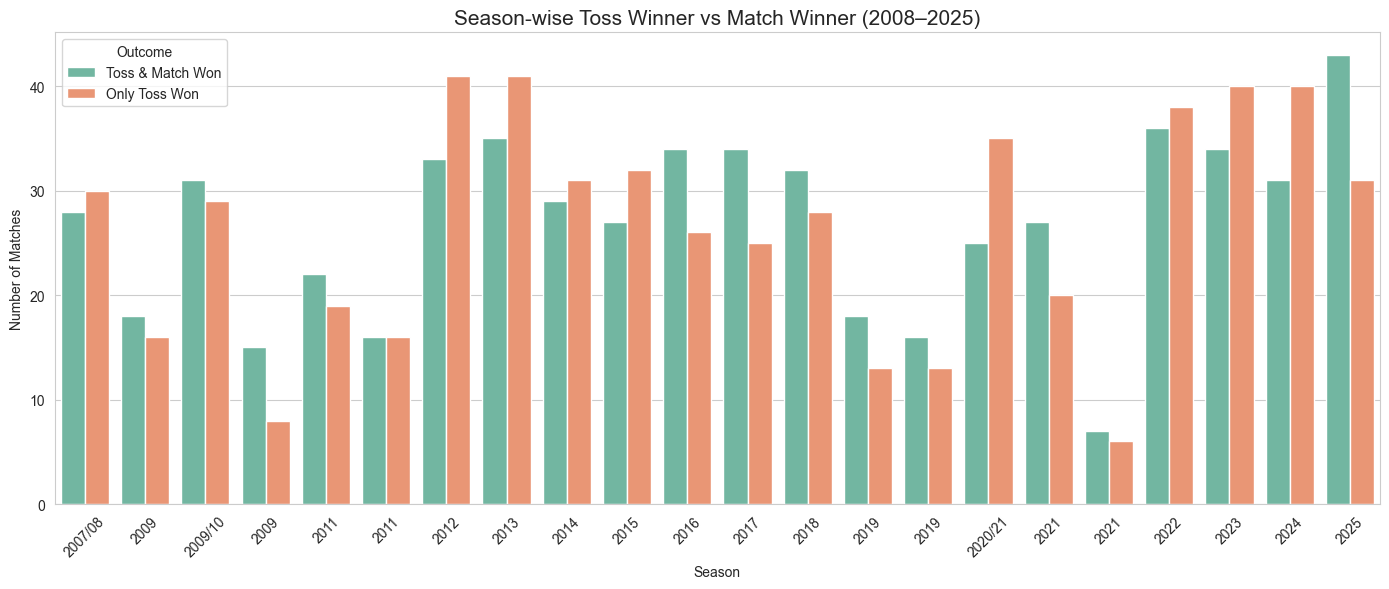

In [18]:
# Extract relevant columns and drop duplicates
toss_match_season = df.drop_duplicates('match_id')[['match_id', 'season', 'toss_winner', 'match_won_by']]

# Create indicator column
toss_match_season['Toss_Match_Win'] = toss_match_season['toss_winner'] == toss_match_season['match_won_by']

# Calculate count per season
season_toss_win = toss_match_season.groupby('season')['Toss_Match_Win'].value_counts().unstack().fillna(0)
season_toss_win.columns = ['Only Toss Won', 'Toss & Match Won']  # False then True
season_toss_win = season_toss_win.reset_index()

# Convert season to year for sorting (if needed)
def season_to_year(season):
    season = str(season)
    if '/' in season:
        return int(season.split('/')[0])
    return int(season)

season_toss_win['Year'] = season_toss_win['season'].apply(season_to_year)
season_toss_win = season_toss_win.sort_values('Year')

# Plot grouped bar chart
plt.figure(figsize=(14,6))
season_toss_win_melted = season_toss_win.melt(id_vars=['season'], value_vars=['Toss & Match Won', 'Only Toss Won'], 
                                              var_name='Outcome', value_name='Matches')

sns.barplot(data=season_toss_win_melted, x='season', y='Matches', hue='Outcome', palette='Set2')

plt.title('Season-wise Toss Winner vs Match Winner (2008–2025)', fontsize=15)
plt.xlabel('Season')
plt.ylabel('Number of Matches')
plt.xticks(rotation=45)
plt.legend(title='Outcome')
plt.tight_layout()
plt.show()


# Season-wise Toss Decision Trend

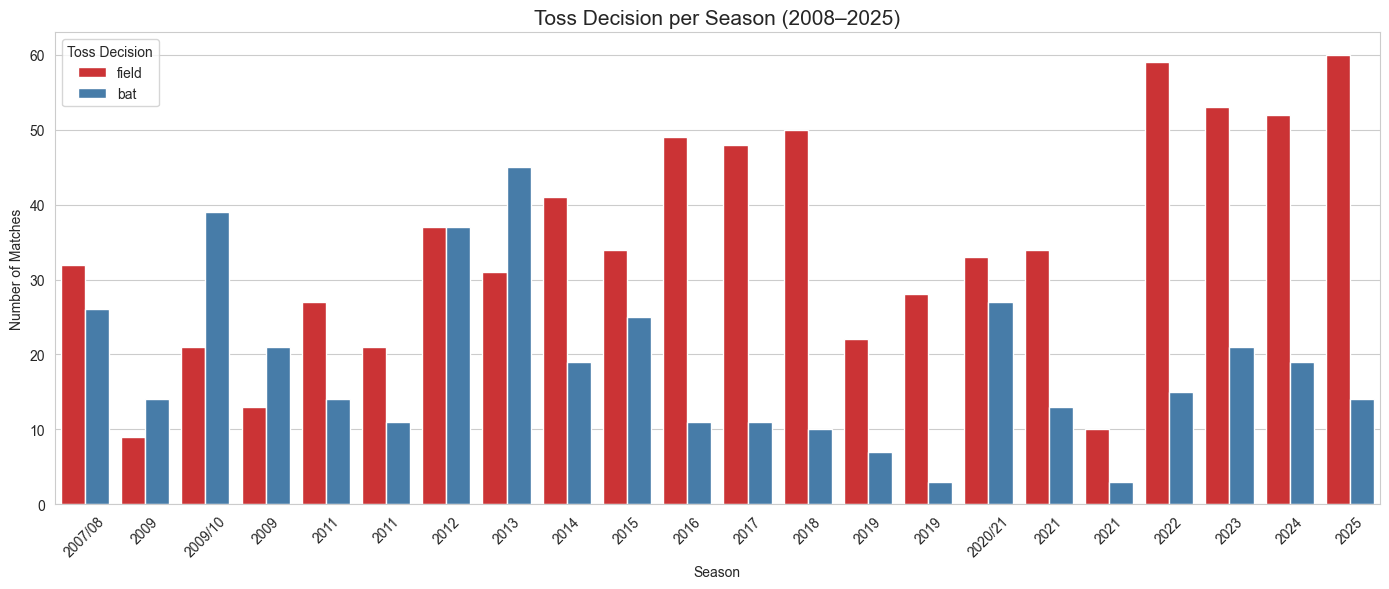

In [19]:
# Get unique toss decisions per match
toss_decisions = df.drop_duplicates('match_id')[['match_id', 'season', 'toss_decision']]

# Count toss decisions per season
toss_decision_trend = toss_decisions.groupby(['season', 'toss_decision']).size().reset_index(name='Count')

# Convert season to year for sorting
def season_to_year(season):
    season = str(season)
    if '/' in season:
        return int(season.split('/')[0])
    return int(season)

toss_decision_trend['Year'] = toss_decision_trend['season'].apply(season_to_year)
toss_decision_trend = toss_decision_trend.sort_values('Year')

# Plot
plt.figure(figsize=(14,6))
sns.barplot(data=toss_decision_trend, x='season', y='Count', hue='toss_decision', palette='Set1')

plt.title('Toss Decision per Season (2008–2025)', fontsize=15)
plt.xlabel('Season')
plt.ylabel('Number of Matches')
plt.xticks(rotation=45)
plt.legend(title='Toss Decision')
plt.tight_layout()
plt.show()


<center><h1 style="font-size:40px;"><b>BATTING PERFORMANCE ANALYSIS</b></h1></center>


## Top Run-Scorers Overall

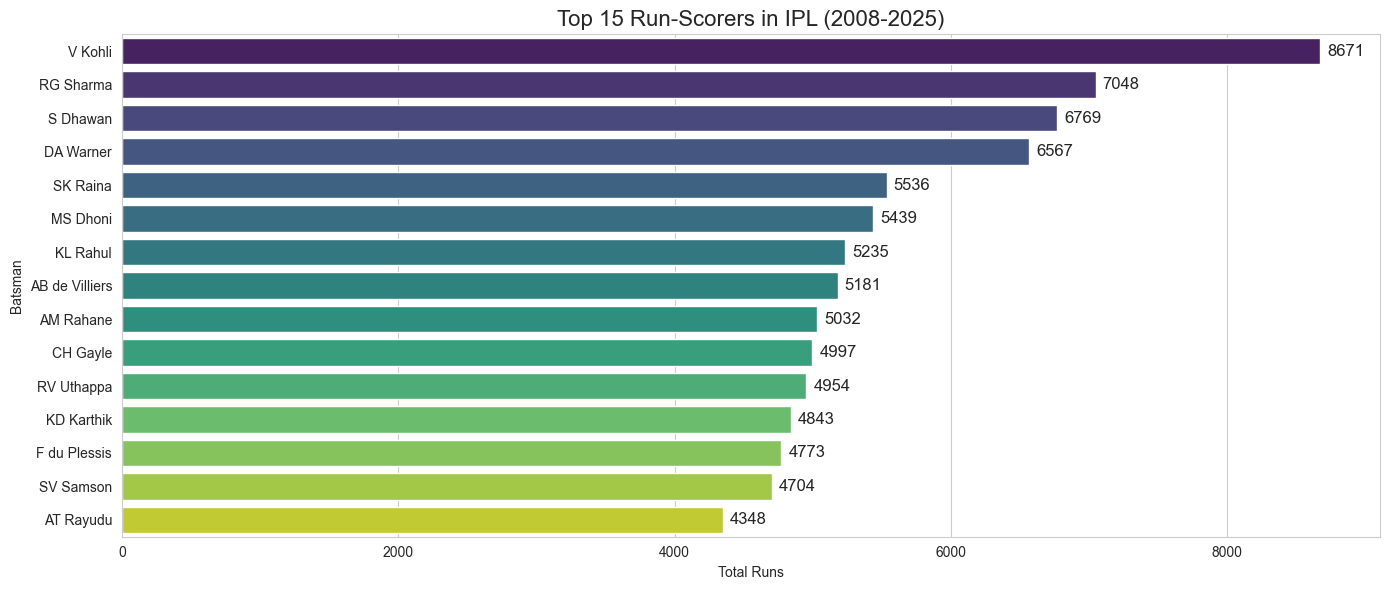

In [20]:
# Aggregate total runs scored by each batter
total_runs = df.groupby('batter')['runs_batter'].sum().reset_index()

# Sort and get top 15 run-scorers
top_scorers = total_runs.sort_values(by='runs_batter', ascending=False).head(15)

plt.figure(figsize=(14,6))
sns.barplot(data=top_scorers, y='batter', x='runs_batter', palette='viridis')
plt.title('Top 15 Run-Scorers in IPL (2008-2025)', fontsize=16)
plt.xlabel('Total Runs')
plt.ylabel('Batsman')

# Add run counts on bars
for i, row in enumerate(top_scorers.itertuples()):
    plt.text(row.runs_batter + 50, i, f"{int(row.runs_batter)}", va='center', fontsize=12)

plt.tight_layout()
plt.show()


## Runs Scored per Season by Top Batsmen

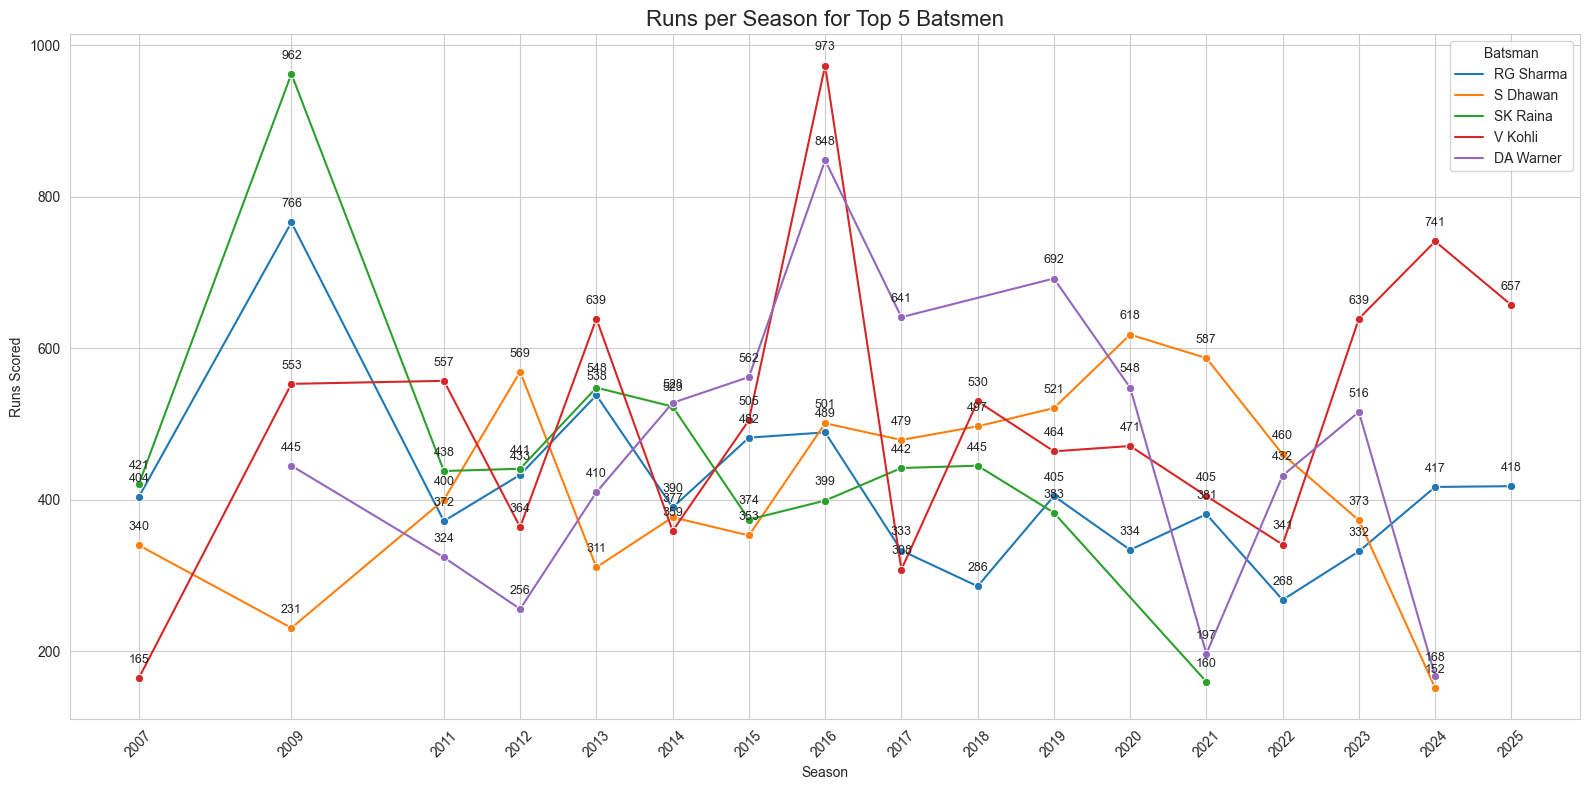

In [21]:
# Clean 'season' values into integer 'year'
def season_to_year(season):
    season = str(season)
    if '/' in season:
        return int(season.split('/')[0])
    return int(season)

df['year'] = df['season'].apply(season_to_year)

# Get top 5 batsmen by total runs
top_5_batsmen = df.groupby('batter')['runs_batter'].sum().sort_values(ascending=False).head(5).index.tolist()

# Filter data
df_top5 = df[df['batter'].isin(top_5_batsmen)]

# Aggregate runs per year per batsman
season_runs = df_top5.groupby(['year', 'batter'])['runs_batter'].sum().reset_index()

# Plot
plt.figure(figsize=(16,8))
sns.lineplot(data=season_runs, x='year', y='runs_batter', hue='batter', marker='o', palette='tab10')
plt.title('Runs per Season for Top 5 Batsmen', fontsize=16)
plt.xlabel('Season')
plt.ylabel('Runs Scored')
plt.xticks(season_runs['year'].unique(), rotation=45)
plt.legend(title='Batsman')

# Annotate data points
for _, row in season_runs.iterrows():
    plt.text(row['year'], row['runs_batter']+20, int(row['runs_batter']), fontsize=9, ha='center')

plt.tight_layout()
plt.show()


## Runs per Season Top 5 Batsmen

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))
sns.barplot(data=season_runs, x='year', y='runs_batter', hue='batter', palette='tab10')

plt.title('Runs per Season for Top 5 Batsmen', fontsize=16)
plt.xlabel('Season')
plt.ylabel('Runs Scored')
plt.xticks(rotation=45)

# Move legend to the right outside the plot
plt.legend(title='Batsman', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

# Annotate bars with run values
ax = plt.gca()
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}',
                    (bar.get_x() + bar.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=9, rotation=90,
                    xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()


## Best Strike Rate of Batsmen

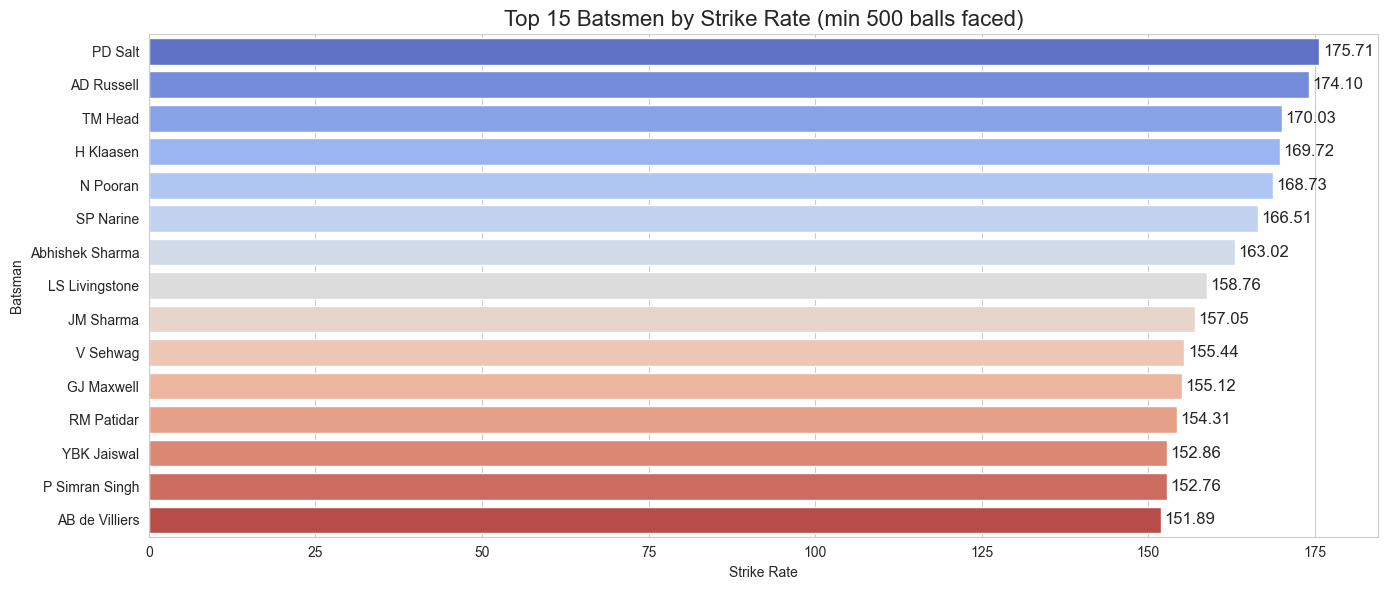

In [23]:
# Calculate strike rate = (Total Runs / Total Balls Faced) * 100
strike_data = df.groupby('batter').agg({'runs_batter': 'sum', 'balls_faced': 'sum'}).reset_index()
strike_data['strike_rate'] = (strike_data['runs_batter'] / strike_data['balls_faced']) * 100

# Filter top batsmen (minimum 500 balls faced for significance)
strike_data_filtered = strike_data[strike_data['balls_faced'] >= 500]

# Top 15 strike rates
top_strikers = strike_data_filtered.sort_values('strike_rate', ascending=False).head(15)

plt.figure(figsize=(14,6))
sns.barplot(data=top_strikers, y='batter', x='strike_rate', palette='coolwarm')
plt.title('Top 15 Batsmen by Strike Rate (min 500 balls faced)', fontsize=16)
plt.xlabel('Strike Rate')
plt.ylabel('Batsman')

for i, row in enumerate(top_strikers.itertuples()):
    plt.text(row.strike_rate + 0.5, i, f"{row.strike_rate:.2f}", va='center', fontsize=12)

plt.tight_layout()
plt.show()

## Best Batting Average

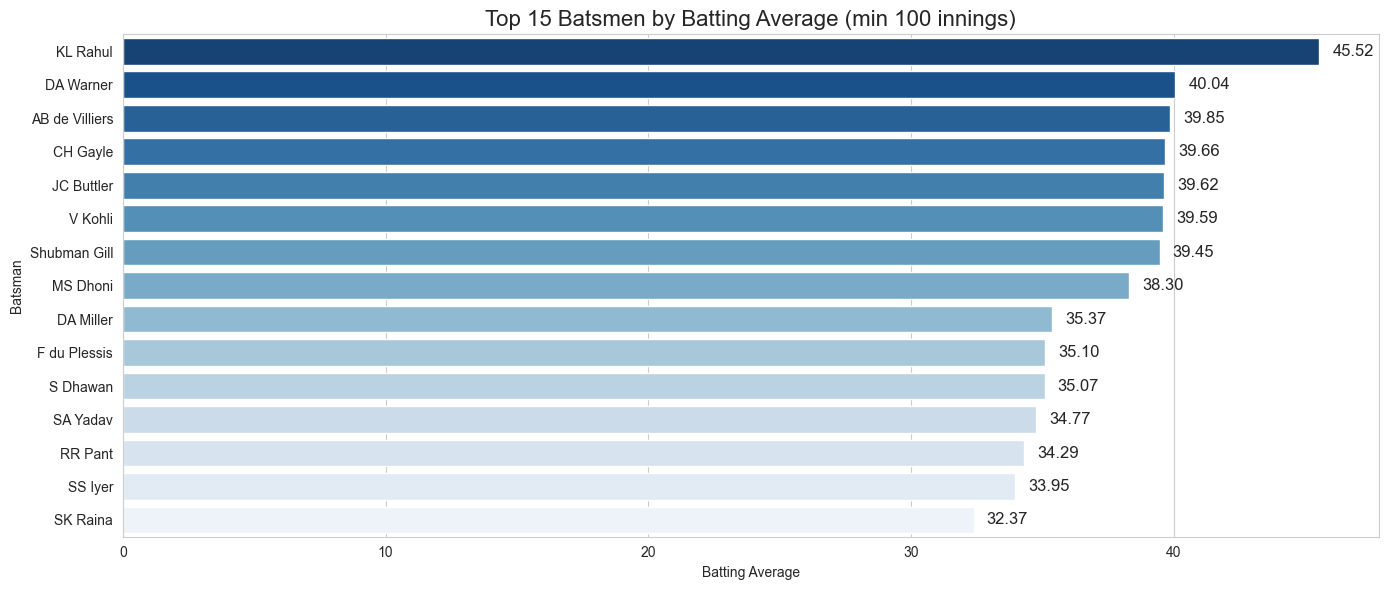

In [24]:
# Total runs scored by each batter
runs_sum = df.groupby('batter')['runs_batter'].sum().reset_index()

# Number of times player got out (player_out == batter)
dismissals = df[df['player_out'].notna()].groupby('player_out').size().reset_index(name='outs')
dismissals.rename(columns={'player_out': 'batter'}, inplace=True)

# Merge runs and dismissals
batting_stats = pd.merge(runs_sum, dismissals, on='batter', how='left').fillna(0)

# Filter players with at least 30 innings (unique match_id + innings)
innings_played = df.groupby(['batter', 'match_id', 'innings']).size().reset_index(name='count')
innings_counts = innings_played.groupby('batter').size().reset_index(name='innings_count')

batting_stats = pd.merge(batting_stats, innings_counts, on='batter', how='left').fillna(0)

# Filter players with minimum 30 innings played
batting_stats = batting_stats[batting_stats['innings_count'] >= 100]

# Calculate batting average (runs / outs), avoid division by zero by replacing 0 outs with NaN
batting_stats['batting_average'] = batting_stats.apply(
    lambda row: row['runs_batter'] / row['outs'] if row['outs'] > 0 else None,
    axis=1
)

# Drop players with undefined average (no outs)
batting_stats = batting_stats.dropna(subset=['batting_average'])

# Top 15 batsmen by batting average
top_avg_batsmen = batting_stats.sort_values('batting_average', ascending=False).head(15)

# Plotting
plt.figure(figsize=(14,6))
sns.barplot(data=top_avg_batsmen, y='batter', x='batting_average', palette='Blues_r')
plt.title('Top 15 Batsmen by Batting Average (min 100 innings)', fontsize=16)
plt.xlabel('Batting Average')
plt.ylabel('Batsman')

for i, row in enumerate(top_avg_batsmen.itertuples()):
    plt.text(row.batting_average + 0.5, i, f"{row.batting_average:.2f}", va='center', fontsize=12)

plt.tight_layout()
plt.show()


## Boundary vs Non-Boundary Runs by Top 10 Batsmen

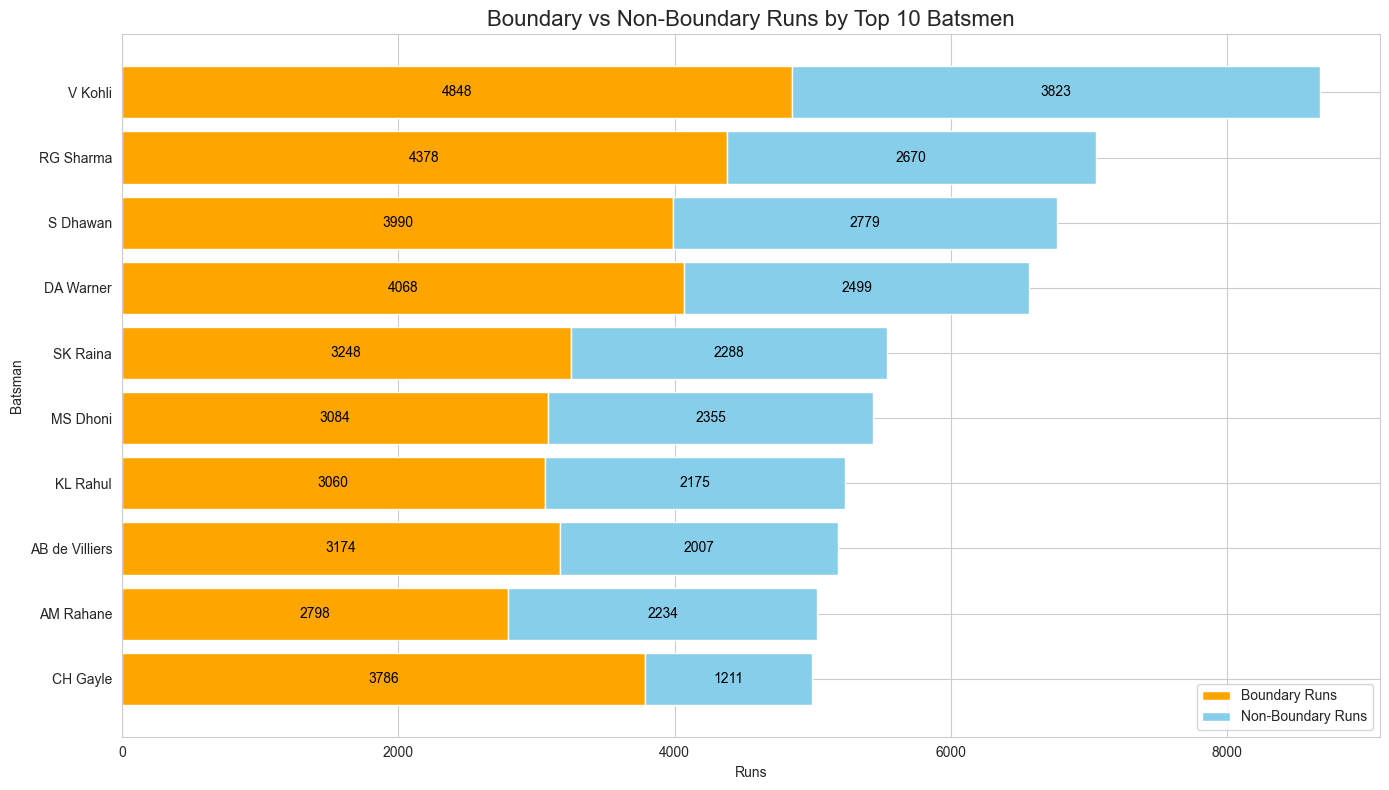

In [25]:
# Aggregate boundary and non-boundary runs per batsman (min 500 runs for clarity)
boundary_runs = df.groupby('batter')['runs_batter'].sum().reset_index()
boundary_runs = boundary_runs[boundary_runs['runs_batter'] >= 500]

# Sum boundary runs (4s and 6s)
fours = df[df['runs_batter'] == 4].groupby('batter')['runs_batter'].count().reset_index(name='fours')
sixes = df[df['runs_batter'] == 6].groupby('batter')['runs_batter'].count().reset_index(name='sixes')

# Merge fours and sixes counts
boundary_counts = pd.merge(fours, sixes, on='batter', how='outer').fillna(0)

# Calculate runs from boundaries
boundary_counts['boundary_runs'] = boundary_counts['fours']*4 + boundary_counts['sixes']*6

# Merge with total runs to get non-boundary runs
boundary_counts = pd.merge(boundary_counts, boundary_runs[['batter', 'runs_batter']], on='batter')
boundary_counts['non_boundary_runs'] = boundary_counts['runs_batter'] - boundary_counts['boundary_runs']

# Top 10 batsmen with most runs
top_10 = boundary_counts.sort_values('runs_batter', ascending=False).head(10)

# Plot stacked bar chart for boundaries and non-boundaries
plt.figure(figsize=(14,8))
bar1 = plt.barh(top_10['batter'], top_10['boundary_runs'], color='orange', label='Boundary Runs')
bar2 = plt.barh(top_10['batter'], top_10['non_boundary_runs'], left=top_10['boundary_runs'], color='skyblue', label='Non-Boundary Runs')

plt.title('Boundary vs Non-Boundary Runs by Top 10 Batsmen', fontsize=16)
plt.xlabel('Runs')
plt.ylabel('Batsman')
plt.legend()
plt.gca().invert_yaxis()

# Adding labels on the bars
for i, (bound, non_bound) in enumerate(zip(top_10['boundary_runs'], top_10['non_boundary_runs'])):
    plt.text(bound / 2, i, f"{int(bound)}", va='center', ha='center', color='black', fontsize=10)
    plt.text(bound + non_bound / 2, i, f"{int(non_bound)}", va='center', ha='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()


## Runs Distribution by Batting Position

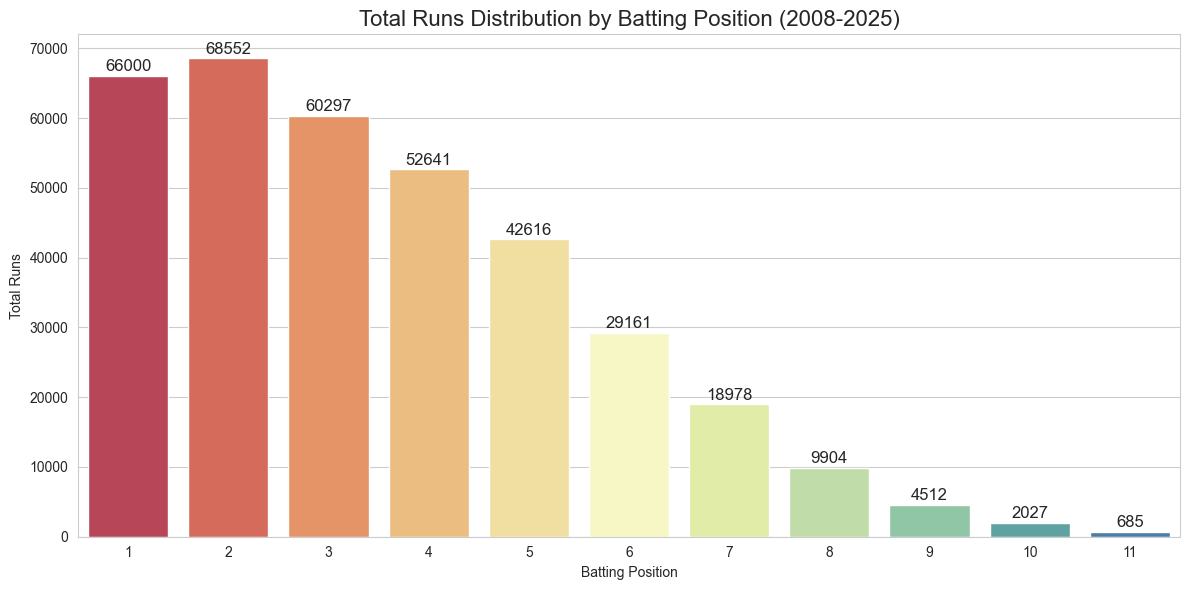

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter relevant columns and drop duplicates of balls to avoid double counting
bat_pos_runs = df[['bat_pos', 'runs_batter']]

# Group by batting position and sum runs
runs_by_bat_pos = bat_pos_runs.groupby('bat_pos')['runs_batter'].sum().reset_index()

# Sort by batting position for better visualization
runs_by_bat_pos = runs_by_bat_pos.sort_values('bat_pos')

plt.figure(figsize=(12,6))
sns.barplot(data=runs_by_bat_pos, x='bat_pos', y='runs_batter', palette='Spectral')

plt.title('Total Runs Distribution by Batting Position (2008-2025)', fontsize=16)
plt.xlabel('Batting Position')
plt.ylabel('Total Runs')
plt.xticks(rotation=0)

# Add count labels on bars
for i, row in runs_by_bat_pos.iterrows():
    plt.text(i, row['runs_batter'] + max(runs_by_bat_pos['runs_batter']) * 0.01, int(row['runs_batter']), 
             ha='center', fontsize=12)

plt.tight_layout()
plt.show()


## Consistency: Count of Scores 30+, 50+, and 100+ per Batsman

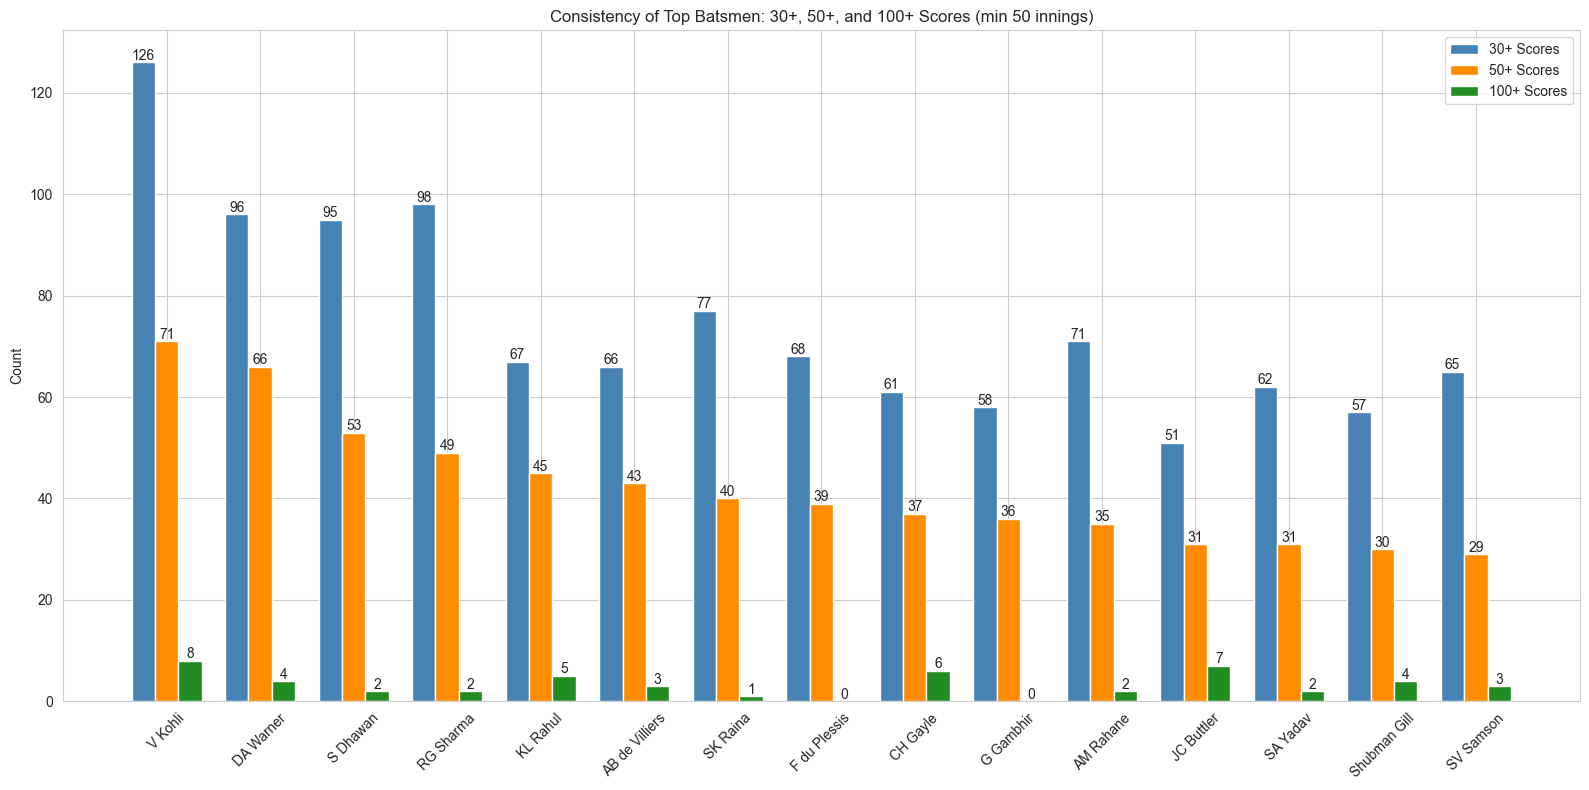

In [27]:
import numpy as np

# Define scoring categories per ball (ball-level data)
# But we need to aggregate per innings per batsman to count 30+, 50+, 100+ scores

# First, aggregate runs per innings per batsman
bat_innings_runs = df.groupby(['batter', 'match_id', 'innings'])['runs_batter'].sum().reset_index()

# Define conditions for scores
bat_innings_runs['30_plus'] = np.where(bat_innings_runs['runs_batter'] >= 30, 1, 0)
bat_innings_runs['50_plus'] = np.where(bat_innings_runs['runs_batter'] >= 50, 1, 0)
bat_innings_runs['100_plus'] = np.where(bat_innings_runs['runs_batter'] >= 100, 1, 0)

# Aggregate count of each score type per batsman
consistency = bat_innings_runs.groupby('batter')[['30_plus', '50_plus', '100_plus']].sum().reset_index()

# Filter batsmen with minimum 30 innings played for meaningful consistency
innings_played = bat_innings_runs.groupby('batter').size().reset_index(name='innings_count')
consistency = consistency.merge(innings_played, on='batter')
consistency = consistency[consistency['innings_count'] >= 50]

# Sort by 50+ scores descending
consistency = consistency.sort_values('50_plus', ascending=False).head(15)

plt.figure(figsize=(16,8))

bar_width = 0.25
index = np.arange(len(consistency))

plt.bar(index, consistency['30_plus'], bar_width, label='30+ Scores', color='steelblue')
plt.bar(index + bar_width, consistency['50_plus'], bar_width, label='50+ Scores', color='darkorange')
plt.bar(index + 2*bar_width, consistency['100_plus'], bar_width, label='100+ Scores', color='forestgreen')

plt.xticks(index + bar_width, consistency['batter'], rotation=45)
plt.ylabel('Count')
plt.title('Consistency of Top Batsmen: 30+, 50+, and 100+ Scores (min 50 innings)')

for i in range(len(consistency)):
    plt.text(i, consistency['30_plus'].values[i] + 0.5, consistency['30_plus'].values[i], ha='center', fontsize=10)
    plt.text(i + bar_width, consistency['50_plus'].values[i] + 0.5, consistency['50_plus'].values[i], ha='center', fontsize=10)
    plt.text(i + 2*bar_width, consistency['100_plus'].values[i] + 0.5, consistency['100_plus'].values[i], ha='center', fontsize=10)

plt.legend()
plt.tight_layout()
plt.show()


## Boundaries per Innings — Average Number of 4s and 6s per Innings per Batsman

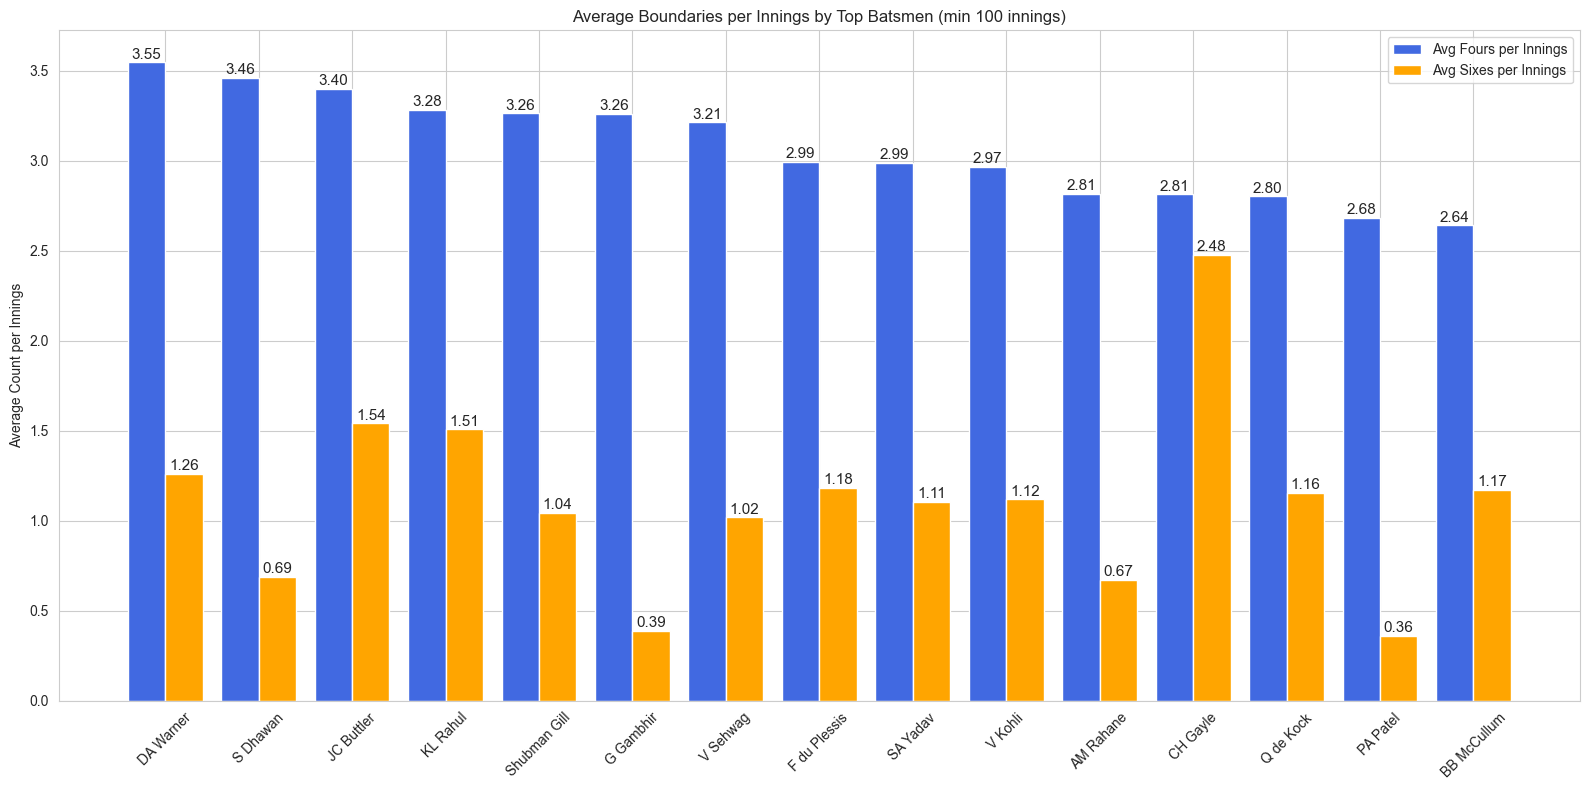

In [28]:
# Filter rows where runs came from boundaries (4s and 6s)
df['is_four'] = df['runs_batter'] == 4
df['is_six'] = df['runs_batter'] == 6

# Calculate total 4s and 6s per batsman per innings
boundaries_per_innings = df.groupby(['batter', 'match_id', 'innings']).agg({
    'is_four': 'sum',
    'is_six': 'sum'
}).reset_index()

# Calculate average boundaries per innings per batsman
avg_boundaries = boundaries_per_innings.groupby('batter').agg({
    'is_four': 'mean',
    'is_six': 'mean'
}).reset_index()

# Filter batsmen with minimum 30 innings played
innings_counts = boundaries_per_innings.groupby('batter').size().reset_index(name='innings_count')
avg_boundaries = avg_boundaries.merge(innings_counts, on='batter')
avg_boundaries = avg_boundaries[avg_boundaries['innings_count'] >= 100]

# Sort by average fours descending
avg_boundaries = avg_boundaries.sort_values('is_four', ascending=False).head(15)

plt.figure(figsize=(16,8))
bar_width = 0.4
index = range(len(avg_boundaries))

plt.bar(index, avg_boundaries['is_four'], width=bar_width, color='royalblue', label='Avg Fours per Innings')
plt.bar([i + bar_width for i in index], avg_boundaries['is_six'], width=bar_width, color='orange', label='Avg Sixes per Innings')

plt.xticks([i + bar_width/2 for i in index], avg_boundaries['batter'], rotation=45)
plt.ylabel('Average Count per Innings')
plt.title('Average Boundaries per Innings by Top Batsmen (min 100 innings)')

# Add labels on bars
for i in range(len(avg_boundaries)):
    plt.text(i, avg_boundaries['is_four'].values[i] + 0.02, f"{avg_boundaries['is_four'].values[i]:.2f}", ha='center', fontsize=11)
    plt.text(i + bar_width, avg_boundaries['is_six'].values[i] + 0.02, f"{avg_boundaries['is_six'].values[i]:.2f}", ha='center', fontsize=11)

plt.legend()
plt.tight_layout()
plt.show()


## Match Situation Impact: Runs Scored in Powerplay, Middle, and Death Overs

<Figure size 1600x800 with 0 Axes>

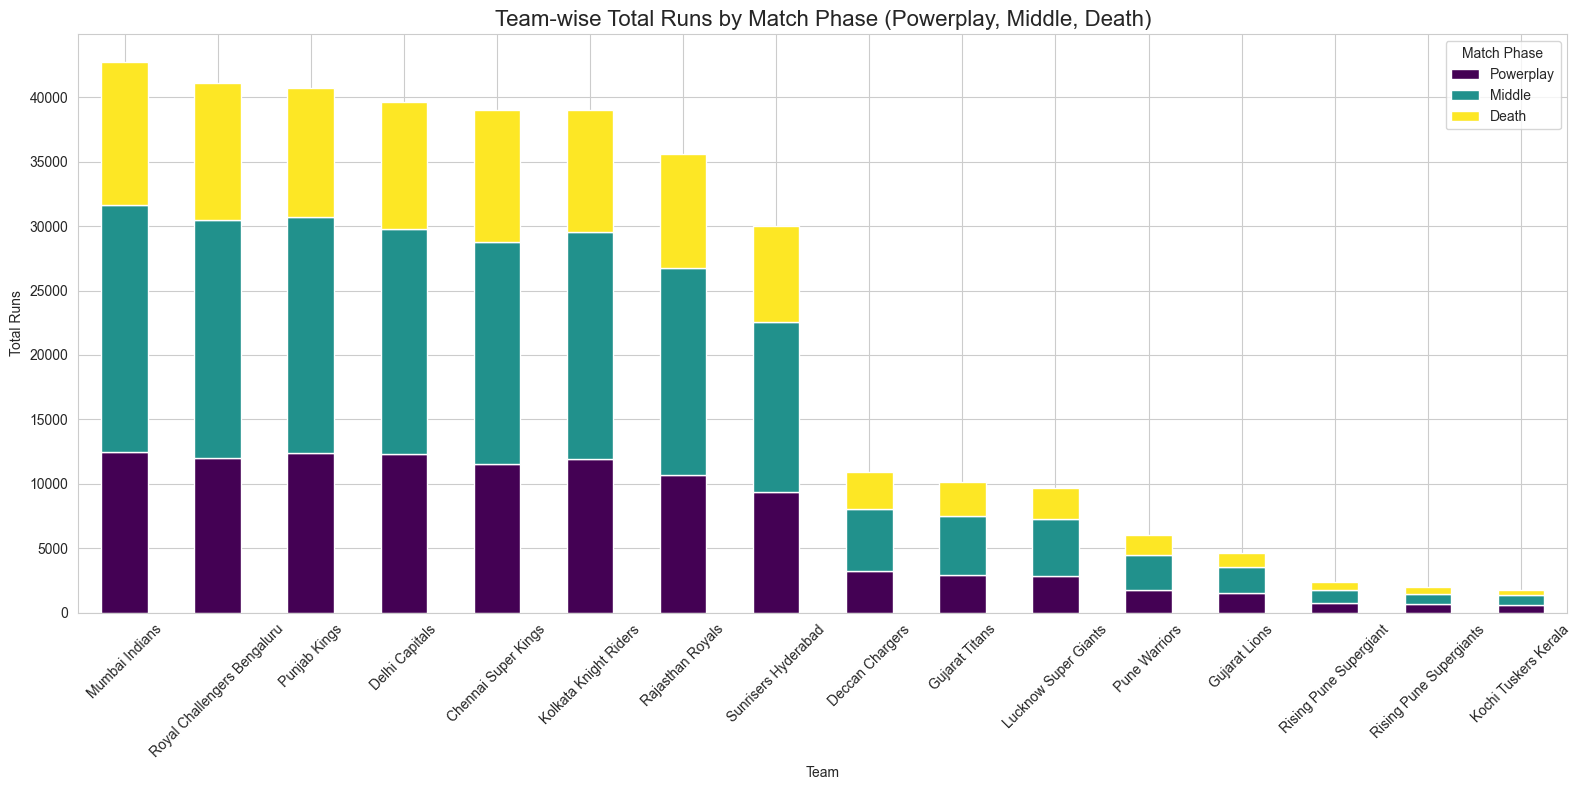

In [29]:
# Categorize overs into match phases
def classify_phase(over):
    if 1 <= over <= 6:
        return 'Powerplay'
    elif 7 <= over <= 15:
        return 'Middle'
    else:
        return 'Death'

df['match_phase'] = df['over'].apply(classify_phase)

# Group by team and match phase
phase_runs = df.groupby(['batting_team', 'match_phase'])['runs_batter'].sum().reset_index()

# Pivot for plotting
phase_pivot = phase_runs.pivot(index='batting_team', columns='match_phase', values='runs_batter').fillna(0)

# Sort by total runs across phases
phase_pivot['Total'] = phase_pivot.sum(axis=1)
phase_pivot = phase_pivot.sort_values('Total', ascending=False)

# Plot
plt.figure(figsize=(16, 8))
phase_pivot[['Powerplay', 'Middle', 'Death']].plot(kind='bar', stacked=True, colormap='viridis', figsize=(16, 8))

plt.title('Team-wise Total Runs by Match Phase (Powerplay, Middle, Death)', fontsize=16)
plt.xlabel('Team')
plt.ylabel('Total Runs')
plt.xticks(rotation=45)
plt.legend(title='Match Phase')
plt.tight_layout()
plt.show()


##  Match Phase-wise Runs per Season

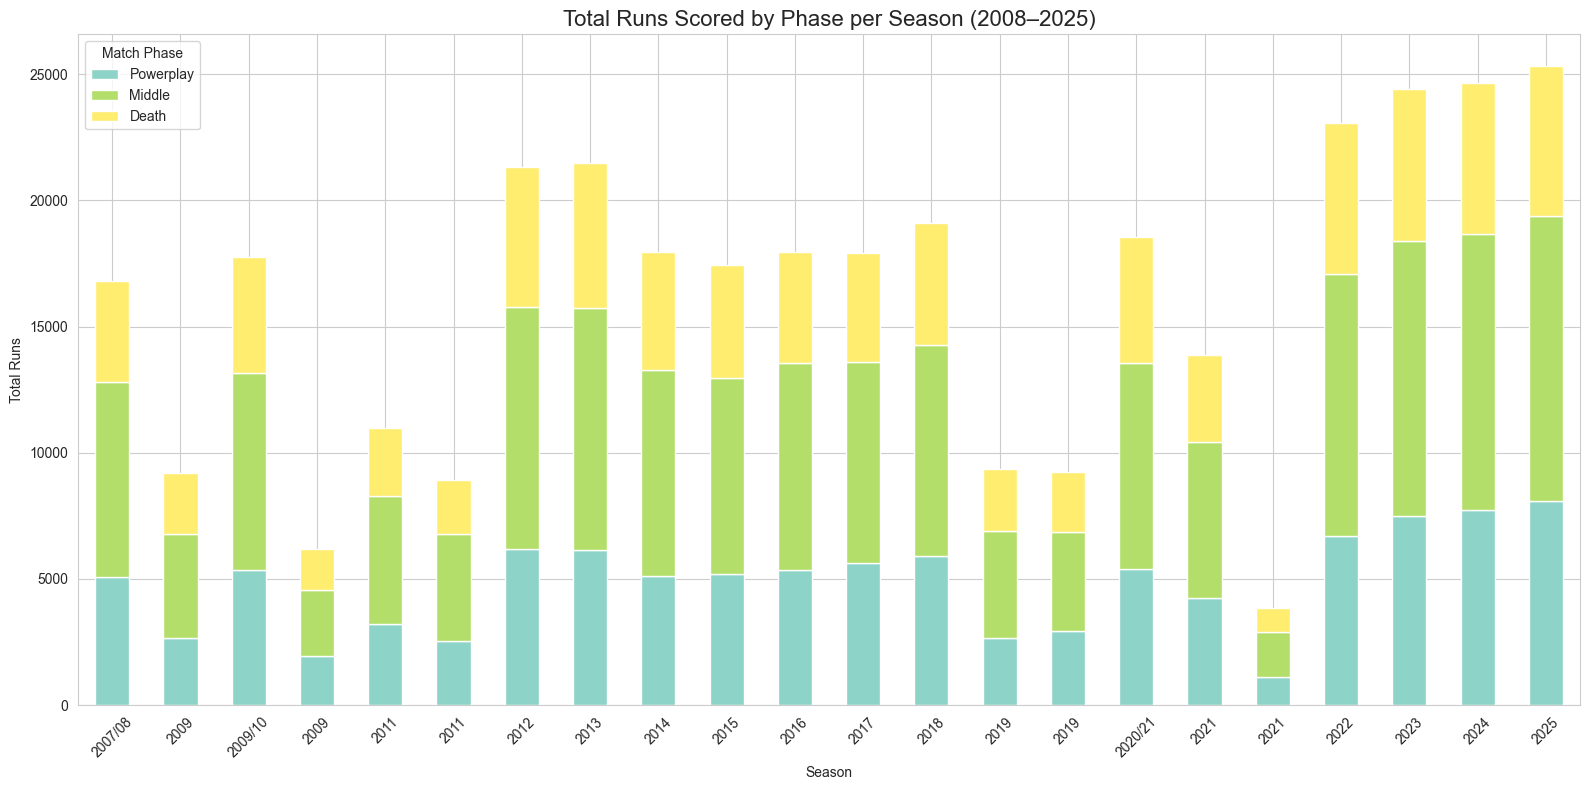

In [30]:
# Classify over into match phases
def classify_phase(over):
    if 1 <= over <= 6:
        return 'Powerplay'
    elif 7 <= over <= 15:
        return 'Middle'
    else:
        return 'Death'

df['match_phase'] = df['over'].apply(classify_phase)

# Group by season and phase
phase_season = df.groupby(['season', 'match_phase'])['runs_batter'].sum().reset_index()

# Pivot for plotting
season_phase_pivot = phase_season.pivot(index='season', columns='match_phase', values='runs_batter').fillna(0)

# Ensure season order
def season_to_year(season):
    season = str(season)
    if '/' in season:
        return int(season.split('/')[0])
    return int(season)

season_phase_pivot['Year'] = season_phase_pivot.index.map(season_to_year)
season_phase_pivot = season_phase_pivot.sort_values('Year').drop(columns='Year')

# Plot
season_phase_pivot[['Powerplay', 'Middle', 'Death']].plot(
    kind='bar', 
    stacked=True, 
    figsize=(16, 8), 
    colormap='Set3'
)

plt.title('Total Runs Scored by Phase per Season (2008–2025)', fontsize=16)
plt.xlabel('Season')
plt.ylabel('Total Runs')
plt.xticks(rotation=45)
plt.legend(title='Match Phase')
plt.tight_layout()
plt.show()


## Best Batting Partnerships by Total Runs

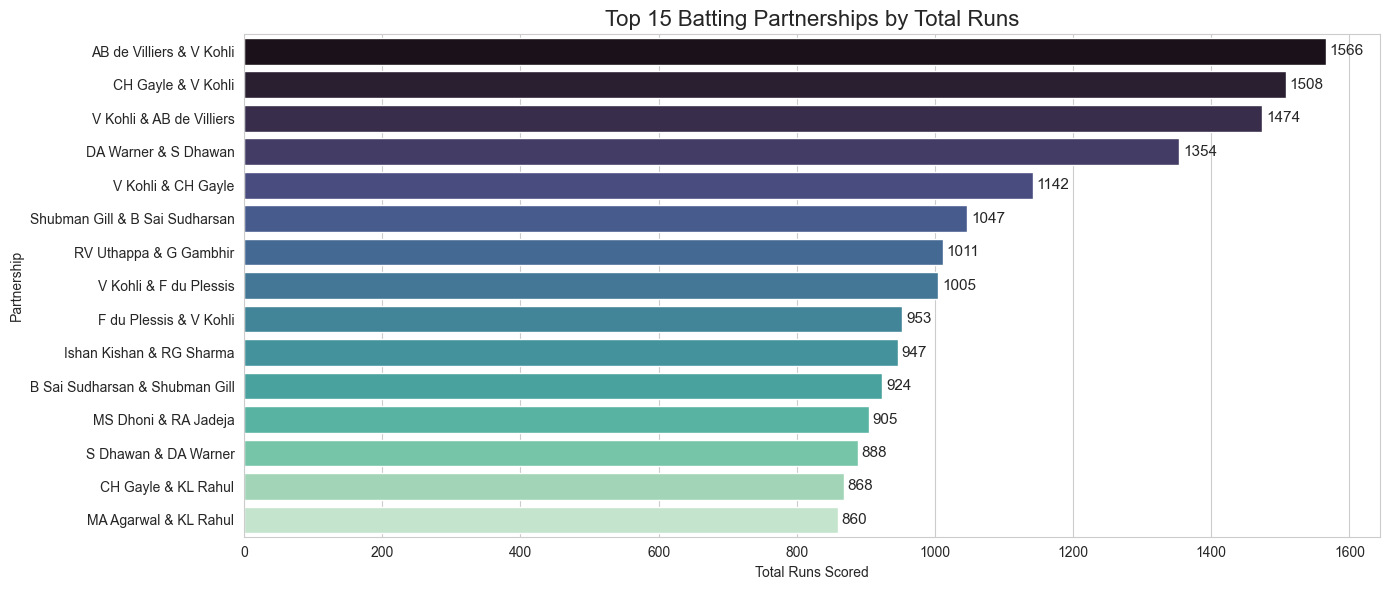

In [70]:
partnership_runs = df.groupby(['batter', 'non_striker'])['runs_batter'].sum().reset_index()

# Create a combined partnership name column
partnership_runs['partnership'] = partnership_runs.apply(lambda row: f"{row['batter']} & {row['non_striker']}", axis=1)

# Sort by total runs scored by partnership descending
top_partnerships = partnership_runs.sort_values('runs_batter', ascending=False).head(15)

plt.figure(figsize=(14,6))
sns.barplot(data=top_partnerships, y='partnership', x='runs_batter', palette='mako')

plt.title('Top 15 Batting Partnerships by Total Runs', fontsize=16)
plt.xlabel('Total Runs Scored')
plt.ylabel('Partnership')

for i, row in enumerate(top_partnerships.itertuples()):
    plt.text(row.runs_batter + 5, i, f"{row.runs_batter}", va='center', fontsize=11)

plt.tight_layout()
plt.show()


## Virat Kohli's performance over the years (Coz he is my fav player)

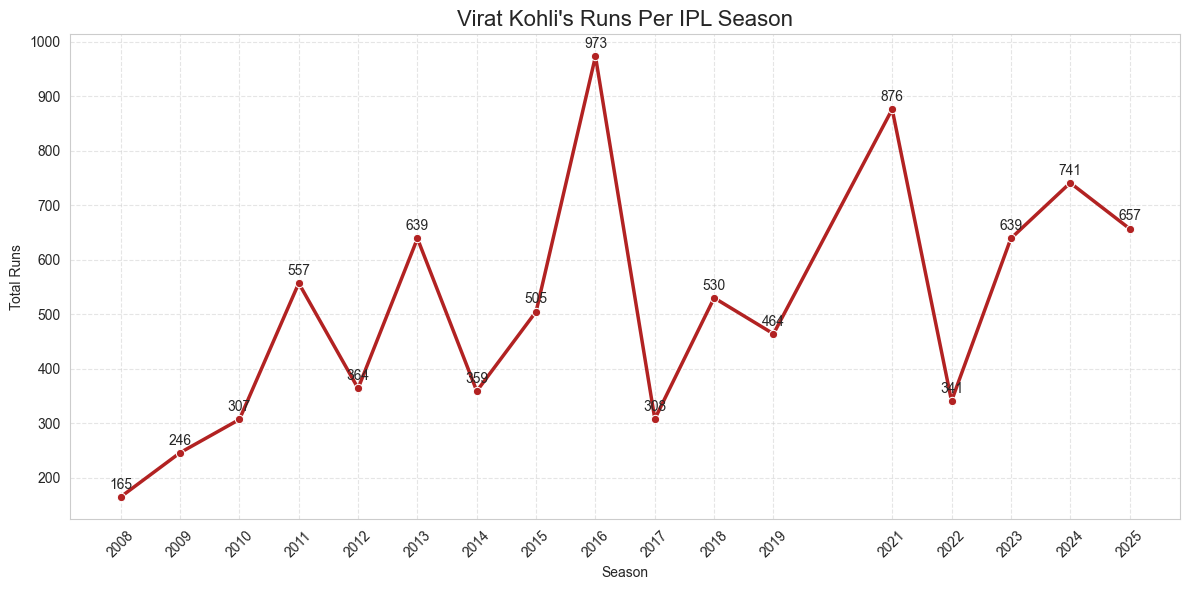

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Convert all seasons to ending year (e.g., '2007/08' → 2008, '2019/20' → 2020)
def season_to_year(season):
    season = str(season)
    if '/' in season:
        parts = season.split('/')
        # Get last two digits of ending year and prepend with the first two digits from starting year
        return int(season[:2] + parts[1])
    return int(season)

# Step 2: Apply the conversion to a new 'season_year' column
df['season_year'] = df['season'].apply(season_to_year)

# Step 3: Filter Virat Kohli's data
kohli_data = df[df['batter'] == 'V Kohli']

# Step 4: Group by season_year and sum the runs
kohli_seasonal_runs = kohli_data.groupby('season_year')['runs_batter'].sum().reset_index()
kohli_seasonal_runs = kohli_seasonal_runs.sort_values('season_year')

# Step 5: Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=kohli_seasonal_runs,
    x='season_year',
    y='runs_batter',
    marker='o',
    color='firebrick',
    linewidth=2.5
)

plt.title("Virat Kohli's Runs Per IPL Season", fontsize=16)
plt.xlabel('Season')
plt.ylabel('Total Runs')
plt.xticks(kohli_seasonal_runs['season_year'].unique(), rotation=45)

# Annotate each data point with run total
for _, row in kohli_seasonal_runs.iterrows():
    plt.text(
        row['season_year'],
        row['runs_batter'] + 15,
        f"{int(row['runs_batter'])}",
        ha='center',
        fontsize=10
    )

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


<center><h1 style="font-size:40px;"><b>BOWLING ANALYSIS</b></h1></center>


## Top Wicket-Takers Overall

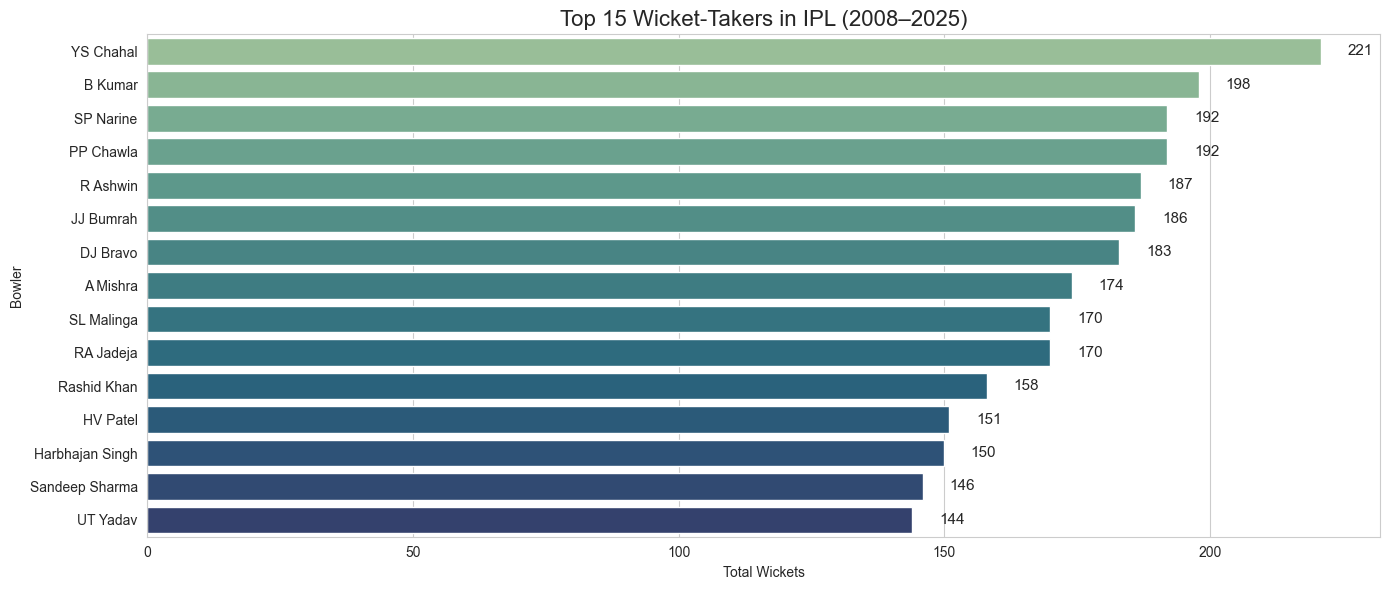

In [80]:
# Filter valid bowler wickets
valid_wickets = df[df['bowler_wicket'] == 1]

# Aggregate total wickets by bowler
top_wicket_takers = valid_wickets.groupby('bowler').size().reset_index(name='total_wickets')
top_wicket_takers = top_wicket_takers.sort_values('total_wickets', ascending=False).head(15)

plt.figure(figsize=(14, 6))
sns.barplot(data=top_wicket_takers, y='bowler', x='total_wickets', palette='crest')

plt.title('Top 15 Wicket-Takers in IPL (2008–2025)', fontsize=16)
plt.xlabel('Total Wickets')
plt.ylabel('Bowler')

# Add visible count labels
for i, row in enumerate(top_wicket_takers.itertuples()):
    plt.text(row.total_wickets + 5, i, f"{row.total_wickets}", va='center', fontsize=11)


plt.tight_layout()
plt.show()


## Bowlers with Most Wickets in a Season

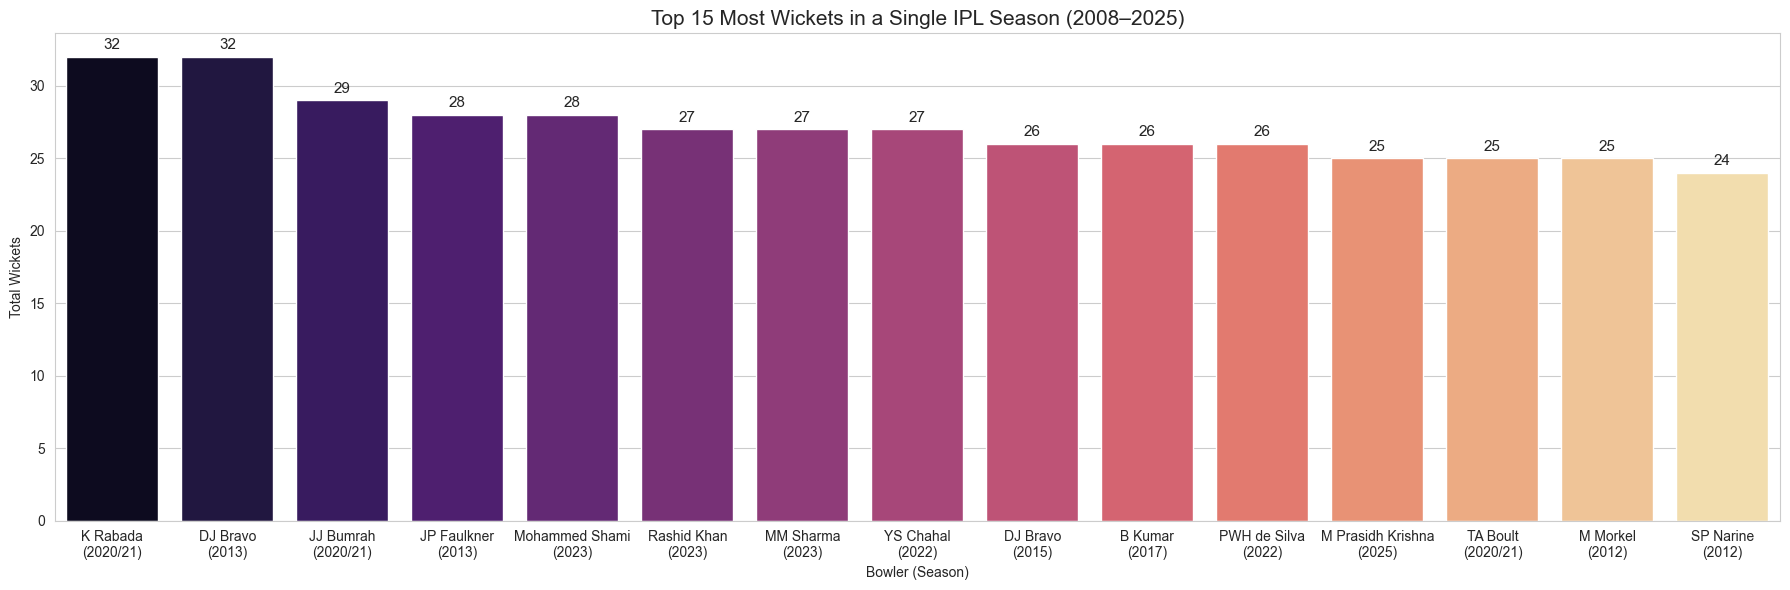

In [81]:
# Filter valid wickets
valid_wickets = df[df['bowler_wicket'] == 1]

# Group by season and bowler to get total wickets in each season
wickets_season = valid_wickets.groupby(['season', 'bowler']).size().reset_index(name='wickets')

# Get top 15 highest seasonal wicket hauls
top_wickets_season = wickets_season.sort_values('wickets', ascending=False).head(15)

# Create a compact label
top_wickets_season['label'] = top_wickets_season['bowler'] + "\n(" + top_wickets_season['season'].astype(str) + ")"

# Plot
plt.figure(figsize=(18, 6))
sns.barplot(data=top_wickets_season, x='label', y='wickets', palette='magma')

plt.title('Top 15 Most Wickets in a Single IPL Season (2008–2025)', fontsize=15)
plt.xlabel('Bowler (Season)')
plt.ylabel('Total Wickets')
plt.xticks(rotation=0, ha='center')

# Add count on top of each bar
for i, row in enumerate(top_wickets_season.itertuples()):
    plt.text(i, row.wickets + 0.5, str(int(row.wickets)), ha='center', fontsize=11)

plt.tight_layout()
plt.show()


## Bowlers with Best Economy

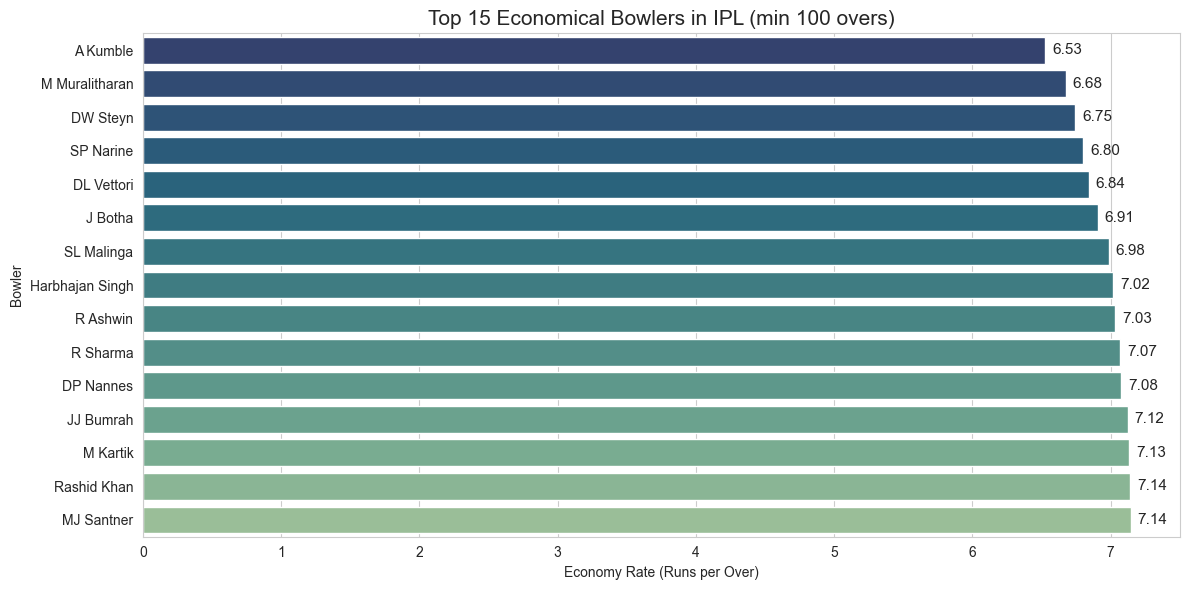

In [82]:
# Filter only valid deliveries
valid_balls = df[df['valid_ball'] == 1]

# Calculate total balls and runs conceded per bowler
bowler_stats = valid_balls.groupby('bowler').agg({
    'ball': 'count',
    'runs_total': 'sum'
}).reset_index()

# Rename columns
bowler_stats.columns = ['bowler', 'balls_bowled', 'runs_conceded']

# Convert balls to overs
bowler_stats['overs'] = bowler_stats['balls_bowled'] / 6

# Filter bowlers with at least 40 overs
bowler_stats = bowler_stats[bowler_stats['overs'] >= 100]

# Calculate economy rate
bowler_stats['economy'] = bowler_stats['runs_conceded'] / bowler_stats['overs']

# Sort by lowest economy
top_economy = bowler_stats.sort_values('economy').head(15)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=top_economy, x='economy', y='bowler', palette='crest_r')

plt.title('Top 15 Economical Bowlers in IPL (min 100 overs)', fontsize=15)
plt.xlabel('Economy Rate (Runs per Over)')
plt.ylabel('Bowler')

# Add values on bars
for i, row in enumerate(top_economy.itertuples()):
    plt.text(row.economy + 0.05, i, f"{row.economy:.2f}", va='center', fontsize=11)

plt.tight_layout()
plt.show()


## Best Bowling Average

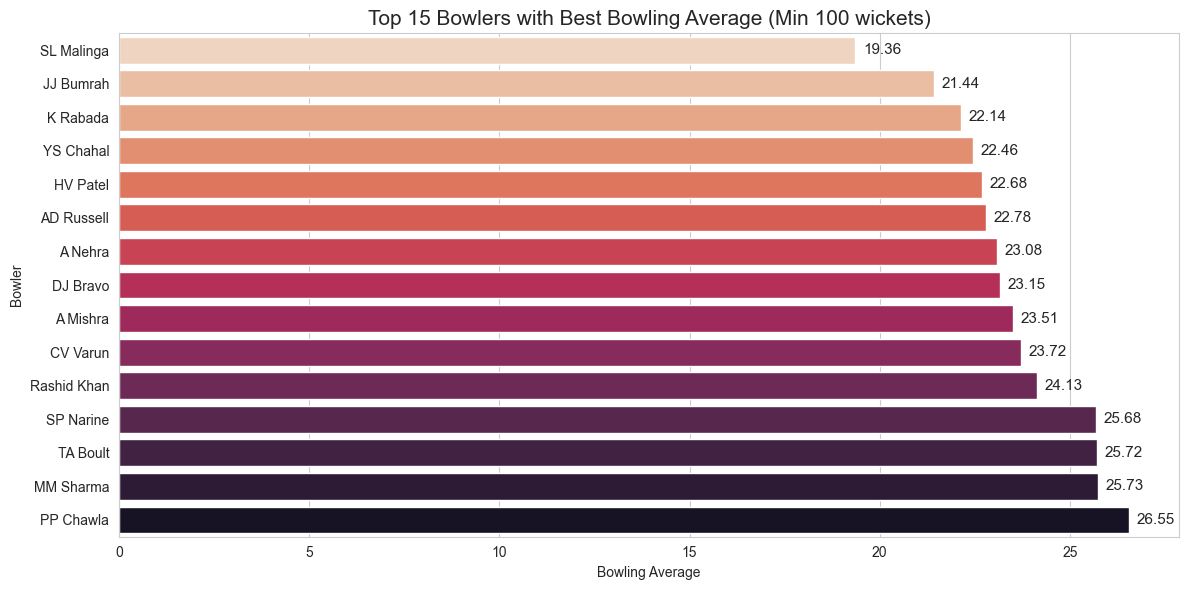

In [83]:
# Filter only valid deliveries where a bowler took a wicket
wicket_df = df[df['bowler_wicket'] == 1]
valid_balls = df[df['valid_ball'] == 1]

# Total wickets per bowler
wicket_counts = wicket_df['bowler'].value_counts().reset_index()
wicket_counts.columns = ['bowler', 'wickets']

# Total runs conceded per bowler
runs_conceded = valid_balls.groupby('bowler')['runs_total'].sum().reset_index()
runs_conceded.columns = ['bowler', 'runs_conceded']

# Merge both
bowler_avg = pd.merge(runs_conceded, wicket_counts, on='bowler')
bowler_avg = bowler_avg[bowler_avg['wickets'] >= 100]  # Only consider 100+ wickets

# Calculate bowling average
bowler_avg['average'] = bowler_avg['runs_conceded'] / bowler_avg['wickets']
top_avg_bowlers = bowler_avg.sort_values('average').head(15)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=top_avg_bowlers, x='average', y='bowler', palette='rocket_r')

plt.title('Top 15 Bowlers with Best Bowling Average (Min 100 wickets)', fontsize=15)
plt.xlabel('Bowling Average')
plt.ylabel('Bowler')

# Add values
for i, row in enumerate(top_avg_bowlers.itertuples()):
    plt.text(row.average + 0.2, i, f"{row.average:.2f}", va='center', fontsize=11)

plt.tight_layout()
plt.show()


## Top 10 Bowlers: Wickets by Match Phase

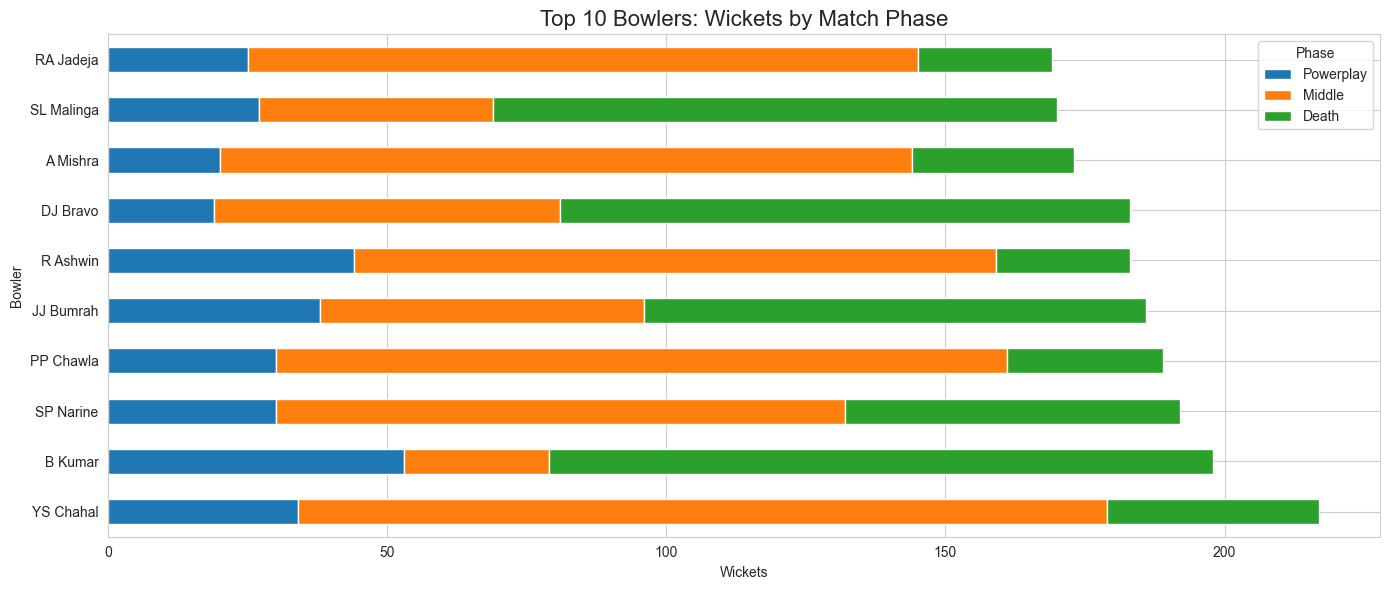

In [84]:
# Filter for valid wickets only
wickets_df = df[(df['bowler_wicket'] == 1) & (df['valid_ball'] == 1)]

# Define phase of over
def get_phase(over):
    if 1 <= over <= 6:
        return 'Powerplay'
    elif 7 <= over <= 15:
        return 'Middle'
    else:
        return 'Death'

wickets_df['phase'] = wickets_df['over'].apply(get_phase)

# Group by bowler and phase
wickets_by_phase = wickets_df.groupby(['bowler', 'phase']).size().reset_index(name='wickets')

# Pivot to create a table: bowler vs phases
wicket_pivot = wickets_by_phase.pivot(index='bowler', columns='phase', values='wickets').fillna(0)
wicket_pivot['Total'] = wicket_pivot.sum(axis=1)

# Filter for bowlers with 100+ wickets
top_phase_bowlers = wicket_pivot[wicket_pivot['Total'] >= 100].sort_values('Total', ascending=False).head(10)

# Plot stacked bar chart
top_phase_bowlers[['Powerplay', 'Middle', 'Death']].plot(
    kind='barh',
    stacked=True,
    figsize=(14,6),
    color=['#1f77b4', '#ff7f0e', '#2ca02c']
)

plt.title('Top 10 Bowlers: Wickets by Match Phase', fontsize=16)
plt.xlabel('Wickets')
plt.ylabel('Bowler')
plt.legend(title='Phase')
plt.tight_layout()
plt.show()


## Bowlers with Best Strike Rate

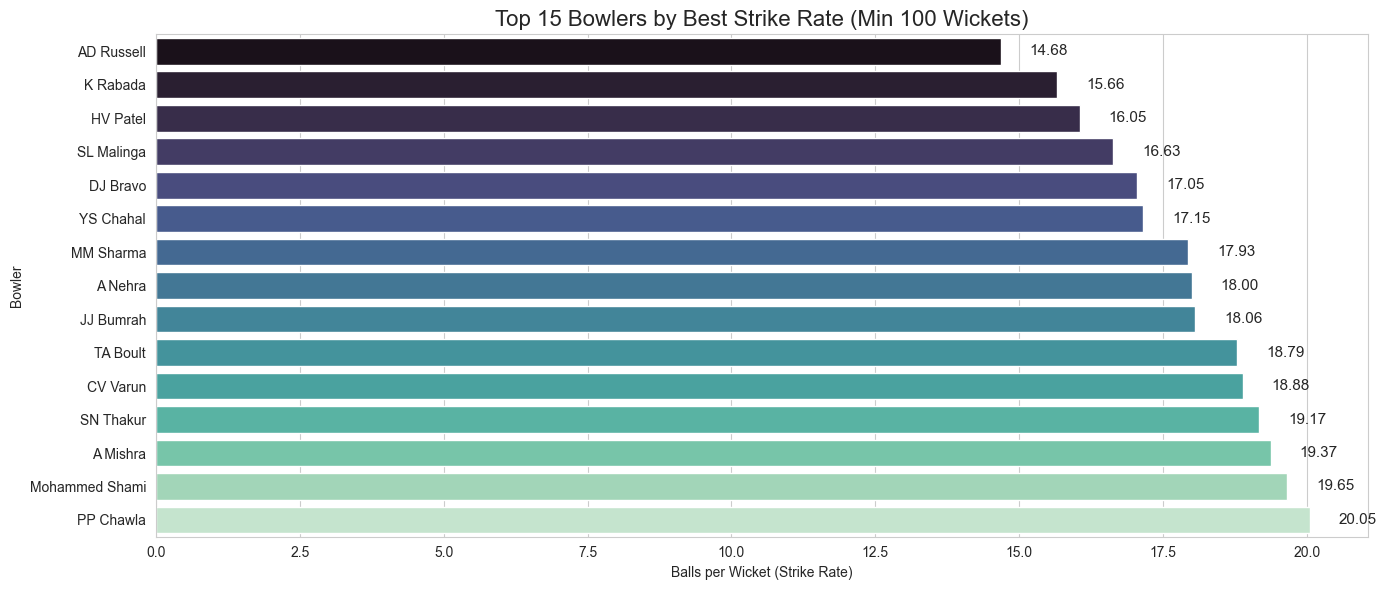

In [85]:
# Only valid deliveries and wickets
valid_bowling = df[df['valid_ball'] == 1]
wickets = df[df['bowler_wicket'] == 1]

# Total balls bowled per bowler
balls_bowled = valid_bowling.groupby('bowler')['ball'].count().reset_index()
balls_bowled.columns = ['bowler', 'balls']

# Total wickets taken per bowler
wickets_taken = wickets.groupby('bowler')['bowler_wicket'].sum().reset_index()
wickets_taken.columns = ['bowler', 'wickets']

# Merge and calculate strike rate
bowling_stats = pd.merge(balls_bowled, wickets_taken, on='bowler')
bowling_stats = bowling_stats[bowling_stats['wickets'] >= 100]
bowling_stats['strike_rate'] = bowling_stats['balls'] / bowling_stats['wickets']

# Top 15 bowlers with best (lowest) strike rate
top_strike_rate = bowling_stats.sort_values('strike_rate').head(15)

# Plot
plt.figure(figsize=(14,6))
sns.barplot(data=top_strike_rate, y='bowler', x='strike_rate', palette='mako')

plt.title('Top 15 Bowlers by Best Strike Rate (Min 100 Wickets)', fontsize=16)
plt.xlabel('Balls per Wicket (Strike Rate)')
plt.ylabel('Bowler')

# Add count on bars
for i, row in enumerate(top_strike_rate.itertuples()):
    plt.text(row.strike_rate + 0.5, i, f"{row.strike_rate:.2f}", va='center', fontsize=11)

plt.tight_layout()
plt.show()

## Bowlers with Best Dot Ball Percentage 

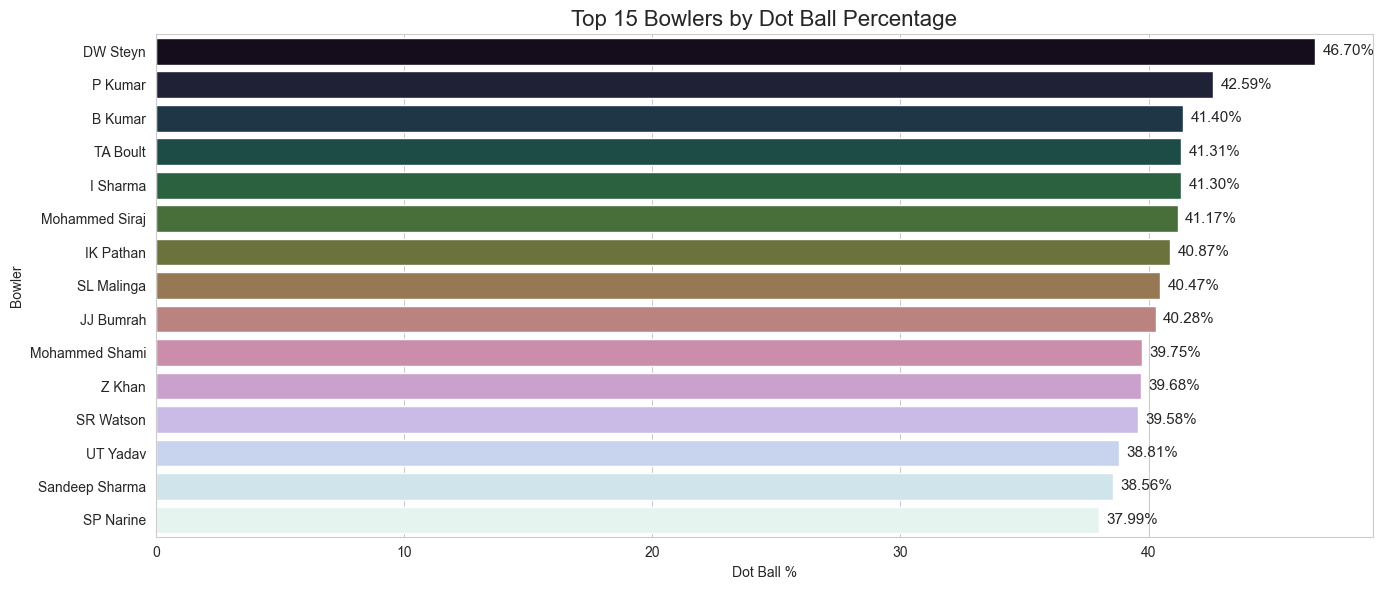

In [86]:
# Filter for valid balls
valid_balls = df[df['valid_ball'] == 1]

# Dot balls are where no runs are scored (not extras, not byes, etc.)
dot_balls = valid_balls[valid_balls['runs_total'] == 0]

# Total balls bowled per bowler
total_balls = valid_balls.groupby('bowler')['ball'].count().reset_index()
total_balls.columns = ['bowler', 'total_balls']

# Total dot balls per bowler
dot_ball_counts = dot_balls.groupby('bowler')['ball'].count().reset_index()
dot_ball_counts.columns = ['bowler', 'dot_balls']

# Merge and compute dot ball %
dot_stats = pd.merge(total_balls, dot_ball_counts, on='bowler', how='left').fillna(0)
dot_stats['dot_pct'] = (dot_stats['dot_balls'] / dot_stats['total_balls']) * 100

# Consider only bowlers with at least 200 overs (2000 balls)
dot_stats = dot_stats[dot_stats['total_balls'] >= 2000]
top_dot_pct = dot_stats.sort_values('dot_pct', ascending=False).head(15)

# Plot
plt.figure(figsize=(14,6))
sns.barplot(data=top_dot_pct, y='bowler', x='dot_pct', palette='cubehelix')

plt.title('Top 15 Bowlers by Dot Ball Percentage', fontsize=16)
plt.xlabel('Dot Ball %')
plt.ylabel('Bowler')

for i, row in enumerate(top_dot_pct.itertuples()):
    plt.text(row.dot_pct + 0.3, i, f"{row.dot_pct:.2f}%", va='center', fontsize=11)

plt.tight_layout()
plt.show()


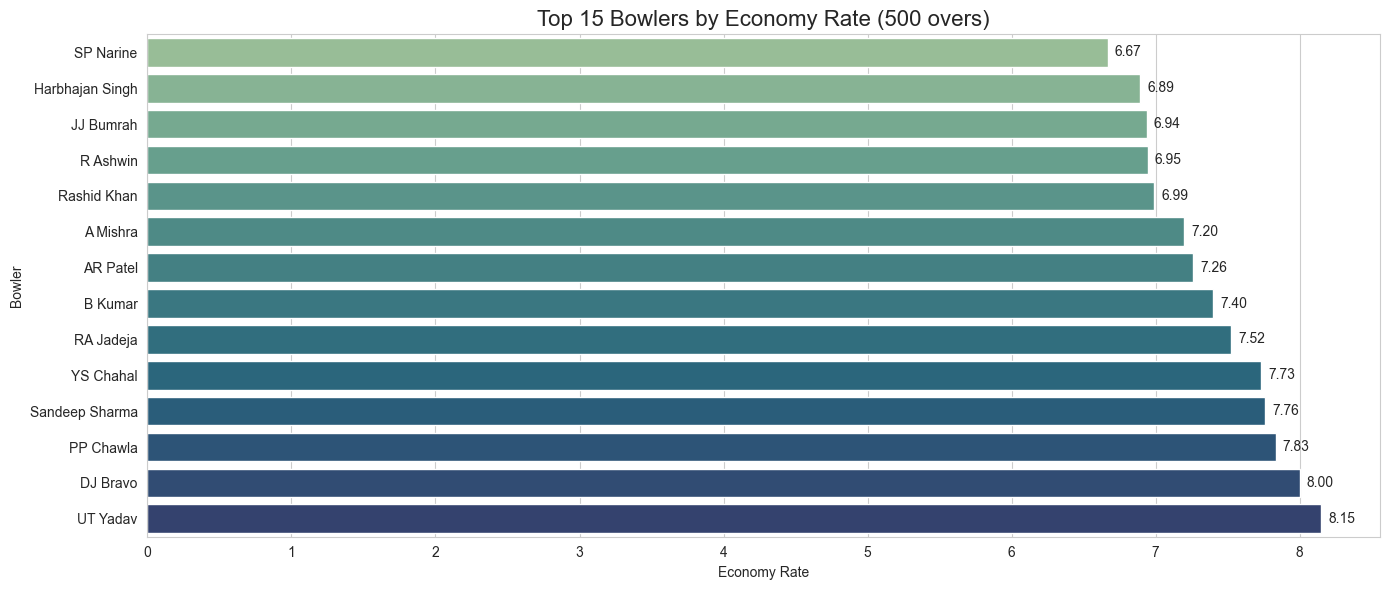

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter only valid deliveries
valid_balls_df = df[df['valid_ball'] == 1]

# Calculate total runs conceded and balls bowled per bowler
bowler_stats = valid_balls_df.groupby('bowler').agg({
    'runs_bowler': 'sum',
    'valid_ball': 'count'
}).reset_index()

# Convert balls to overs and compute economy rate
bowler_stats['overs'] = bowler_stats['valid_ball'] / 6
bowler_stats = bowler_stats[bowler_stats['valid_ball'] >= 3000]  

bowler_stats['economy_rate'] = bowler_stats['runs_bowler'] / bowler_stats['overs']
top_economy_bowlers = bowler_stats.sort_values('economy_rate').head(15)

# Plotting
plt.figure(figsize=(14, 6))
sns.barplot(data=top_economy_bowlers, x='economy_rate', y='bowler', palette='crest')
plt.title('Top 15 Bowlers by Economy Rate (500 overs)', fontsize=16)
plt.xlabel('Economy Rate')
plt.ylabel('Bowler')

# Annotate values
for i, row in enumerate(top_economy_bowlers.itertuples()):
    plt.text(row.economy_rate + 0.05, i, f"{row.economy_rate:.2f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()


## Economy Rate: Pacers vs Spinners

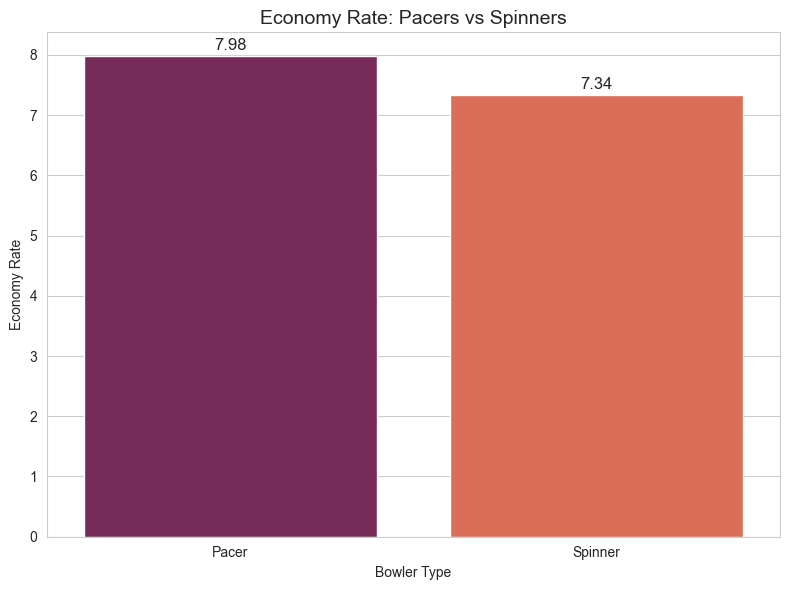

In [88]:
# Simplified: based on common surnames – you can enhance this with actual player type mapping
pacers_keywords = ['Shami', 'Bumrah', 'Boult', 'Siraj', 'Archer', 'Nortje', 'Ishant', 'Unadkat']
spinners_keywords = ['Ashwin', 'Chahal', 'Rashid', 'Mujeeb', 'Kuldeep', 'Zampa', 'Jadeja', 'Harbhajan']

def get_bowler_type(bowler):
    for spin in spinners_keywords:
        if spin in bowler:
            return 'Spinner'
    for pace in pacers_keywords:
        if pace in bowler:
            return 'Pacer'
    return 'Unknown'

df['bowler_type'] = df['bowler'].apply(get_bowler_type)
df_filtered = df[(df['bowler_type'].isin(['Pacer', 'Spinner'])) & (df['valid_ball'] == 1)]

# Calculate total runs and balls per type
type_stats = df_filtered.groupby('bowler_type').agg({
    'runs_bowler': 'sum',
    'valid_ball': 'count'
}).reset_index()
type_stats['economy_rate'] = type_stats['runs_bowler'] / (type_stats['valid_ball'] / 6)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=type_stats, x='bowler_type', y='economy_rate', palette='rocket')
plt.title('Economy Rate: Pacers vs Spinners', fontsize=14)
plt.xlabel('Bowler Type')
plt.ylabel('Economy Rate')

# Annotate
for i, row in type_stats.iterrows():
    plt.text(i, row['economy_rate'] + 0.1, f"{row['economy_rate']:.2f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()


## Total Wickets Taken Per IPL Season

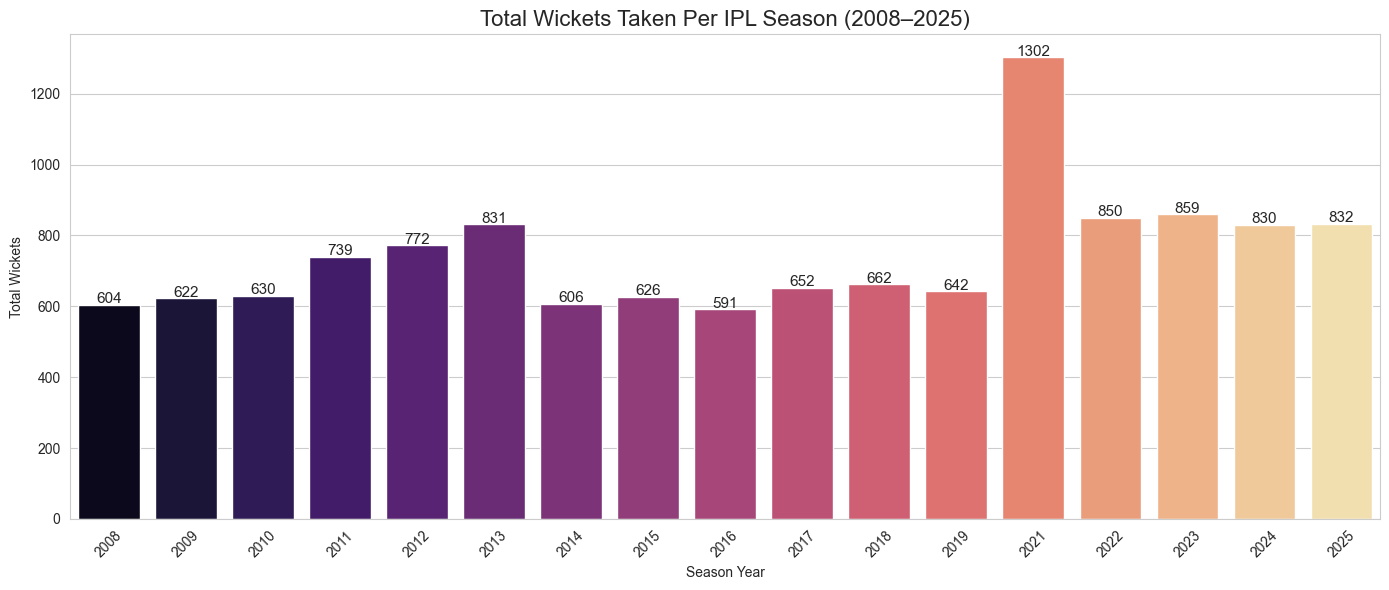

In [89]:
# Ensure 'season_year' is standardized
if 'season_year' not in df.columns:
    def season_to_year(season):
        season = str(season)
        return int(season.split('/')[1]) if '/' in season else int(season)
    df['season_year'] = df['season'].apply(season_to_year)

# Filter only valid dismissals (exclude run outs if needed)
valid_wickets = df[df['bowler_wicket'] == 1]

# Group by year
wickets_per_year = valid_wickets.groupby('season_year')['bowler_wicket'].count().reset_index()
wickets_per_year.columns = ['Season Year', 'Total Wickets']
wickets_per_year = wickets_per_year.sort_values('Season Year')

# Plot
plt.figure(figsize=(14,6))
sns.barplot(data=wickets_per_year, x='Season Year', y='Total Wickets', palette='magma')

plt.title('Total Wickets Taken Per IPL Season (2008–2025)', fontsize=16)
plt.xlabel('Season Year')
plt.ylabel('Total Wickets')
plt.xticks(rotation=45)

# Annotate count
for i, row in wickets_per_year.iterrows():
    plt.text(i, row['Total Wickets'] + 5, f"{row['Total Wickets']}", ha='center', fontsize=11)

plt.tight_layout()
plt.show()


## Best Death Over Bowlers 

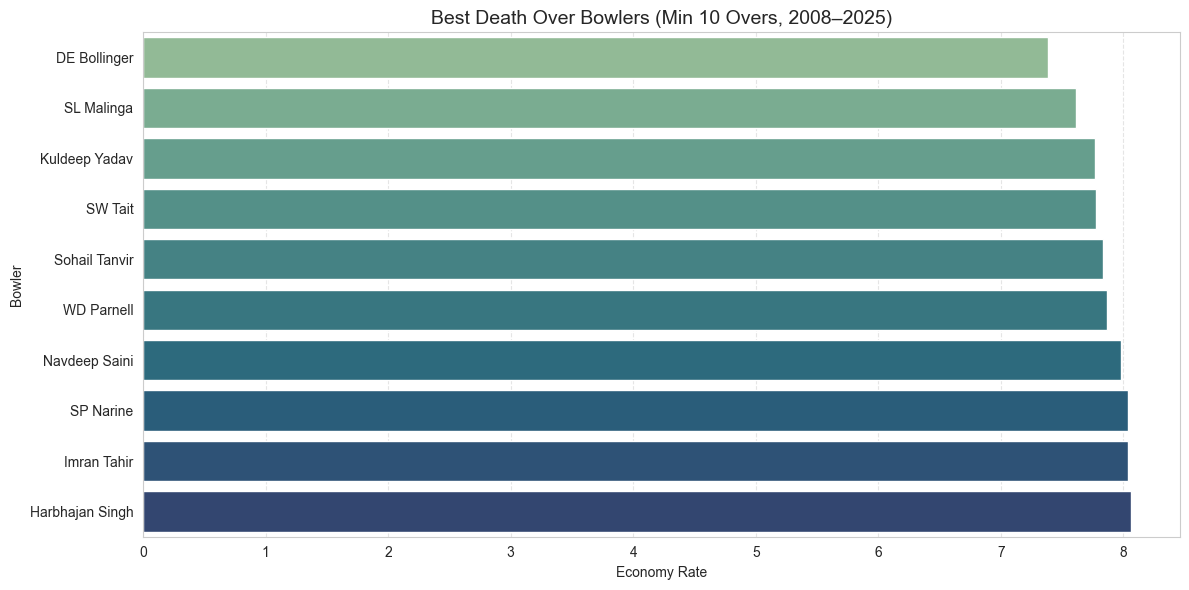

In [90]:
# Filter for death overs (17-20)
death_overs = df[(df['over'] >= 17) & (df['over'] <= 20)]

# Filter only valid deliveries
valid_death = death_overs[death_overs['valid_ball'] == 1]

# Group by bowler
death_bowling = valid_death.groupby('bowler').agg({
    'runs_total': 'sum',
    'valid_ball': 'count'
}).reset_index()

# Calculate overs and economy
death_bowling['overs'] = death_bowling['valid_ball'] / 6
death_bowling = death_bowling[death_bowling['overs'] >= 10]  # Minimum 10 overs
death_bowling['economy'] = death_bowling['runs_total'] / death_bowling['overs']

# Best death bowlers by economy
best_death_bowlers = death_bowling.sort_values(by='economy').head(10)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(data=best_death_bowlers, y='bowler', x='economy', palette='crest')
plt.title("Best Death Over Bowlers (Min 10 Overs, 2008–2025)", fontsize=14)
plt.xlabel("Economy Rate")
plt.ylabel("Bowler")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


<center><h1 style="font-size:40px;"><b>FIELDING ANALYSIS</b></h1></center>

## Fielders by Number of Catches

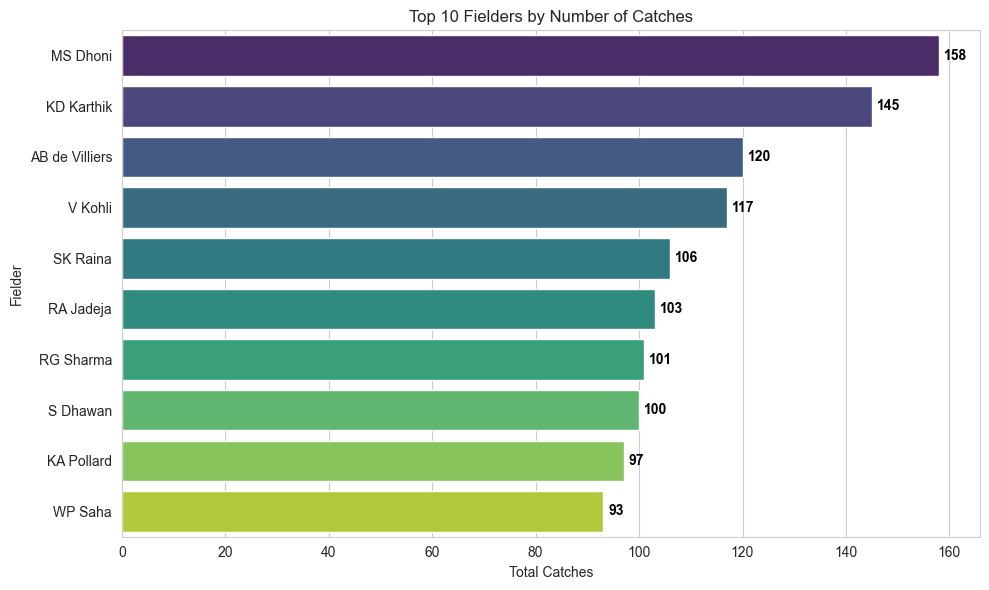

In [91]:
top_fielders = df[df['wicket_kind'] == 'caught']
top_catchers = top_fielders['fielders'].value_counts().head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_catchers.values, y=top_catchers.index, palette='viridis')

# Add value labels
for i, v in enumerate(top_catchers.values):
    ax.text(v + 1, i, str(v), color='black', va='center', fontweight='bold')

plt.title('Top 10 Fielders by Number of Catches')
plt.xlabel('Total Catches')
plt.ylabel('Fielder')
plt.tight_layout()
plt.show()


## Fielders involved in runouts

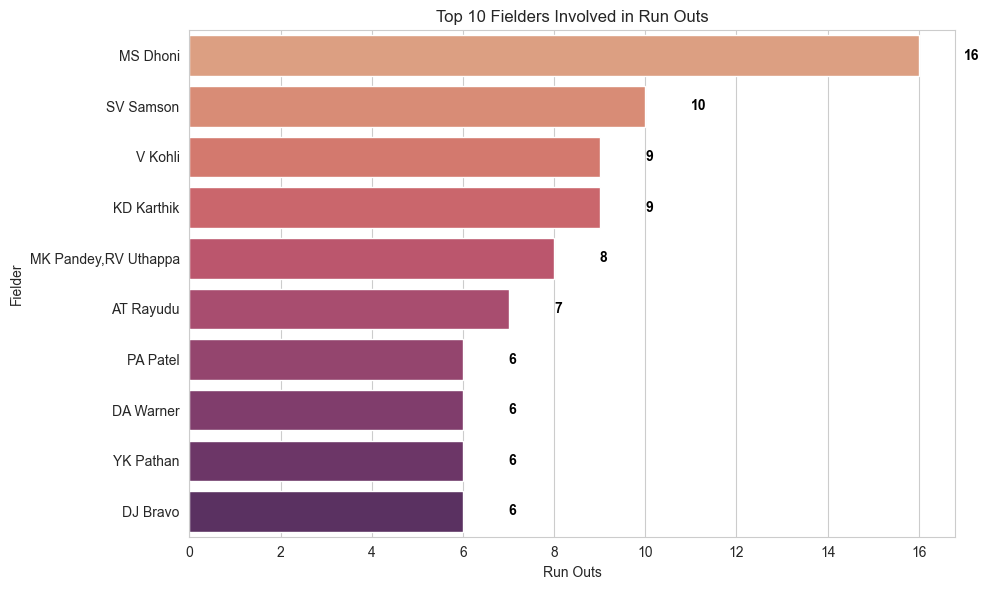

In [92]:
runout_df = df[df['wicket_kind'] == 'run out']
top_runouts = runout_df['fielders'].value_counts().head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_runouts.values, y=top_runouts.index, palette='flare')

# Add value labels
for i, v in enumerate(top_runouts.values):
    ax.text(v + 1, i, str(v), color='black', va='center', fontweight='bold')

plt.title('Top 10 Fielders Involved in Run Outs')
plt.xlabel('Run Outs')
plt.ylabel('Fielder')
plt.tight_layout()
plt.show()


## Teams by Total Fielding Dismissals

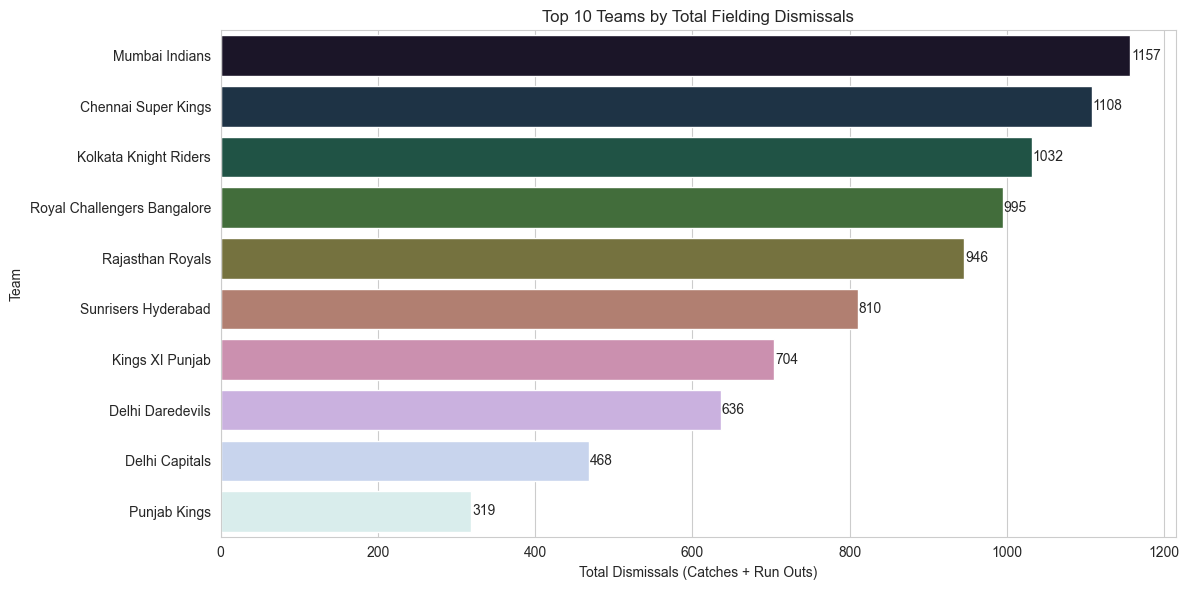

In [93]:
# Run out + catches only (no stumpings)
fielding_team_df = df[df['wicket_kind'].isin(['caught', 'run out']) & df['bowling_team'].notna()]
fielding_team_df = fielding_team_df.copy()
fielding_team_df['fielders'] = fielding_team_df['fielders'].str.split(', ')
fielding_team_df = fielding_team_df.explode('fielders')

team_fielding = fielding_team_df.groupby('bowling_team')['fielders'].count().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=team_fielding.values, y=team_fielding.index, palette='cubehelix')
plt.title("Top 10 Teams by Total Fielding Dismissals")
for i, v in enumerate(team_fielding.values):
    plt.text(v + 1, i, str(v), va='center', fontsize=10)
plt.xlabel("Total Dismissals (Catches + Run Outs)")
plt.ylabel("Team")
plt.tight_layout()
plt.show()


<center><h1 style="font-size:40px;"><b>CHAMPIONS</b></h1></center>

# Most IPL Championships 

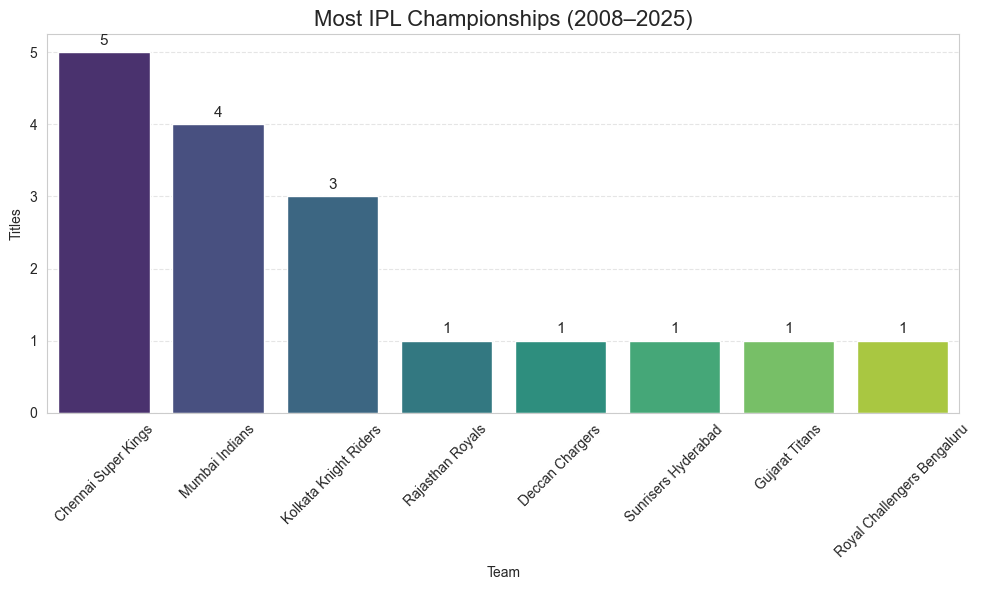

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure season is converted to final year (e.g., '2007/08' → 2008)
def season_to_year(season):
    season = str(season)
    if '/' in season:
        parts = season.split('/')
        return int(season[:2] + parts[1])  # e.g., '2019/20' → 2020
    return int(season)

# Apply standardized season year
df['season_year'] = df['season'].apply(season_to_year)

# Get unique match winners per season (Final winners)
# This assumes last match of each season is the final
winners_per_season = df.drop_duplicates(subset=['season_year', 'match_id'], keep='last')
winners_per_season = winners_per_season.groupby('season_year').tail(1)
season_winners = winners_per_season[['season_year', 'match_won_by']].dropna().reset_index(drop=True)

# ✅ 2. Most Seasons Won (Championship Titles) — Team-wise
title_counts = season_winners['match_won_by'].value_counts().reset_index()
title_counts.columns = ['Team', 'Titles']

# Plot Titles per Team
plt.figure(figsize=(10, 6))
sns.barplot(data=title_counts, x='Team', y='Titles', palette='viridis')

# Annotate count on bars
for i, row in title_counts.iterrows():
    plt.text(i, row['Titles'] + 0.1, row['Titles'], ha='center', fontsize=11)

plt.title('Most IPL Championships (2008–2025)', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Season-wise Winners (2008–2025)


In [95]:
print("IPL Season-wise Champions (2008–2025):")
print(season_winners.sort_values('season_year').reset_index(drop=True))

IPL Season-wise Champions (2008–2025):
    season_year                 match_won_by
0          2008             Rajasthan Royals
1          2009              Deccan Chargers
2          2010          Chennai Super Kings
3          2011          Chennai Super Kings
4          2012        Kolkata Knight Riders
5          2013               Mumbai Indians
6          2014        Kolkata Knight Riders
7          2015               Mumbai Indians
8          2016          Sunrisers Hyderabad
9          2017               Mumbai Indians
10         2018          Chennai Super Kings
11         2019               Mumbai Indians
12         2021          Chennai Super Kings
13         2022               Gujarat Titans
14         2023          Chennai Super Kings
15         2024        Kolkata Knight Riders
16         2025  Royal Challengers Bengaluru
